In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
# %qtconsole

In [2]:
from glob import glob
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr

from src.parameters import PROCESSED_DATA_DIR, STATE_COLORS, STATE_ORDER

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
import matplotlib
import seaborn as sns

from src.parameters import FIGURE_DIR

# Set background and fontsize
rc_params = {
    'pdf.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'ps.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'axes.labelcolor': '#222222',
    'text.color': '#222222',
    'figure.figsize': (7.2, 4.45),
    'font.sans-serif' : 'Helvetica',
    'text.usetex': False,
    'xtick.major.size': 0.00,
    'ytick.major.size': 0.00,
    'axes.labelpad': 0.1,
    }
sns.set(style='white', context='poster', rc=rc_params)

In [4]:
def save_figure(figure_name, is_save_figures=True):
    if is_save_figures:
        figure_name = os.path.join(FIGURE_DIR, figure_name)
        plt.savefig(figure_name + '.pdf', transparent=True, dpi=300, bbox_inches='tight')

In [20]:
data_type, dim = 'clusterless', '1D'

def load_and_preprocess(file_path):
    replay_info = pd.read_csv(file_path).set_index(['animal', 'day', 'epoch', 'ripple_number'])
    return replay_info.loc[replay_info.n_unique_spiking >= n_unique_spiking]
    

n_unique_spiking = 2

file_paths = glob(os.path.join(PROCESSED_DATA_DIR, f'remy_35_02_{data_type}_{dim}_replay_info_shuffle_*.csv'))
replay_infos = [load_and_preprocess(file_path) for file_path in file_paths]

In [22]:
file_path = os.path.join(PROCESSED_DATA_DIR, f'remy_35_02_{data_type}_{dim}_replay_info_actual.csv')
actual_replay_info = load_and_preprocess(file_path)

In [154]:
def plot_percentage(column, ax=None):
    if ax is None:
        ax = plt.gca()
    is_column = [replay_info[column].mean() for replay_info in replay_infos]
    random = sns.stripplot(is_column, size=10, alpha=0.8, ax=ax)
    actual = sns.stripplot([actual_replay_info[column].mean()], color='orange', size=10, ax=ax)
    ax.set_xlim((-0.05, 1))
    ax.set_xlabel('Percentage of\nRipples')
    ax.set_title(f'{column}')
    sns.despine(left=True, ax=ax)
    
def plot_mean(column, ax=None):
    if ax is None:
        ax = plt.gca()
    column_mean = []
    for replay_info in replay_infos:
        try:
            column_mean.append(replay_info[column].mean())
        except KeyError:
            continue
    random = sns.stripplot(column_mean, size=10, alpha=0.8, ax=ax)
    actual = sns.stripplot([actual_replay_info[column].mean()], color='orange', size=10, ax=ax)
    sns.despine(left=True, ax=ax)

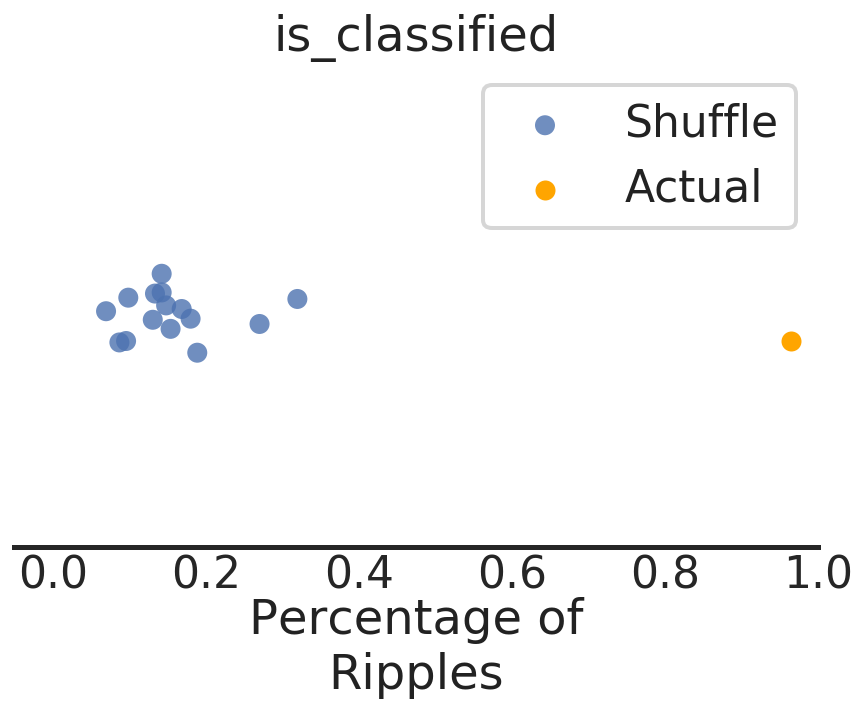

In [157]:
import seaborn as sns

plot_percentage('is_classified')
plt.legend(['Shuffle', 'Actual'])

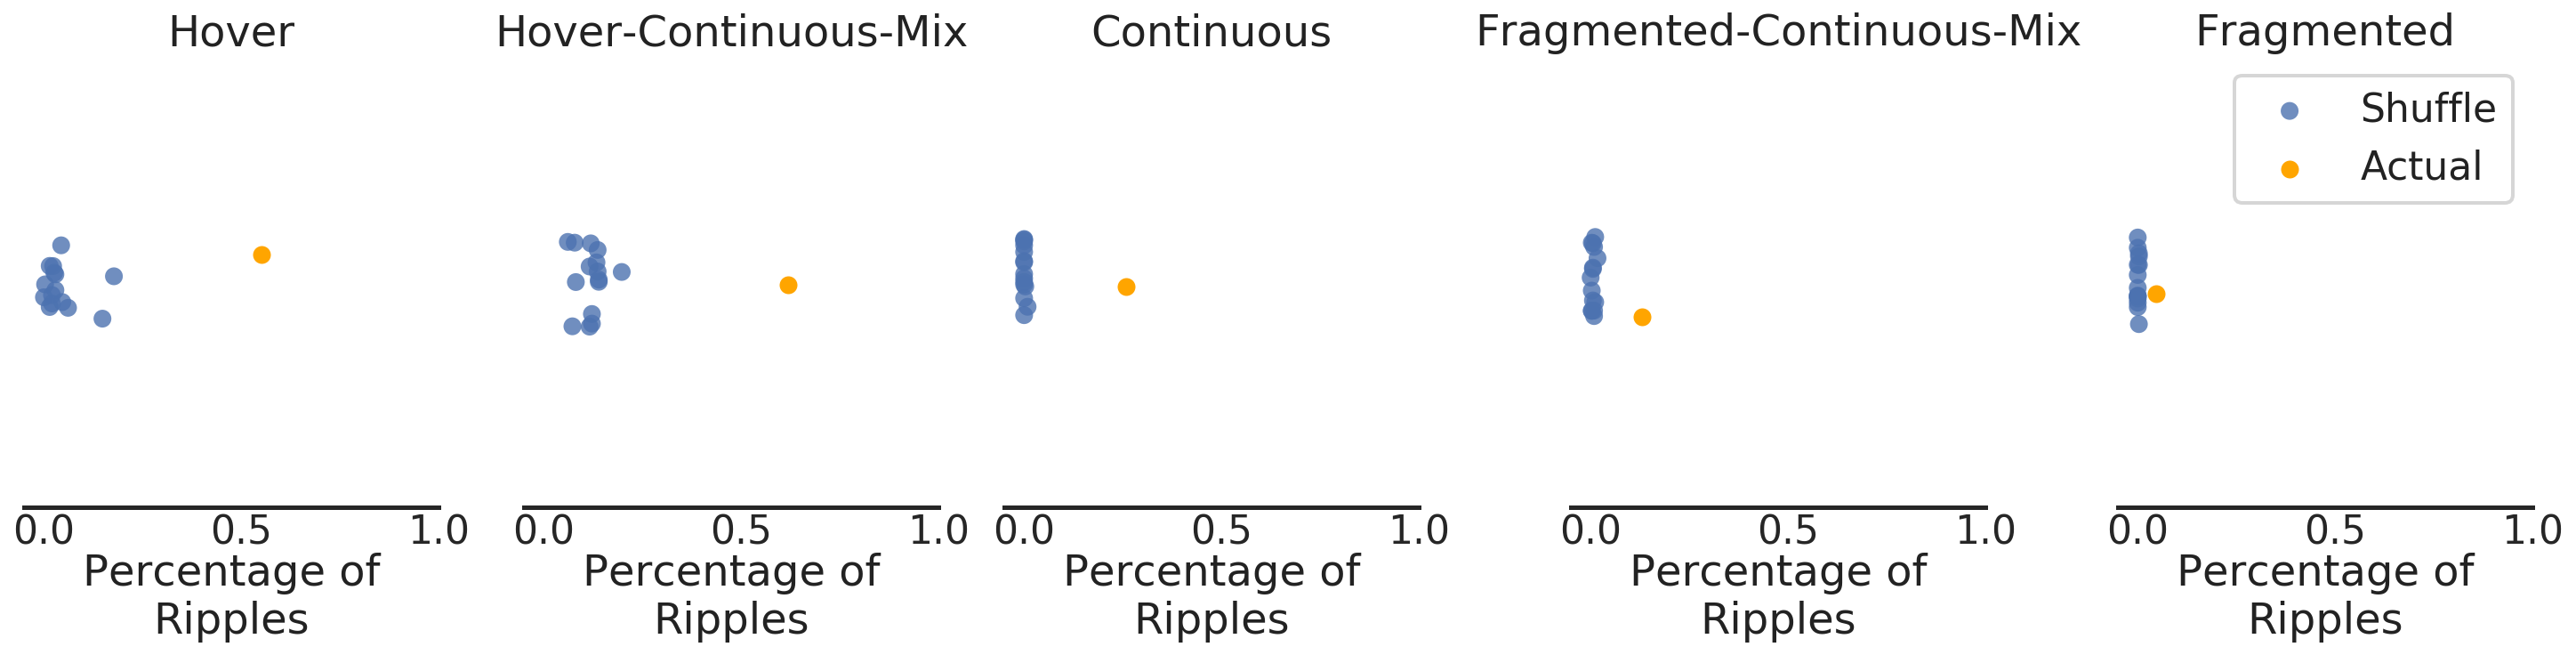

In [125]:
from src.parameters import STATE_ORDER

fig, axes = plt.subplots(1, len(STATE_ORDER), figsize=(20, 5),
                         constrained_layout=True, sharex=True, sharey=True)
for ax, state in zip(axes.ravel(), STATE_ORDER):
    plot_percentage(state, ax=ax)
ax.legend(['Shuffle', 'Actual'])

(-0.005, 0.1)

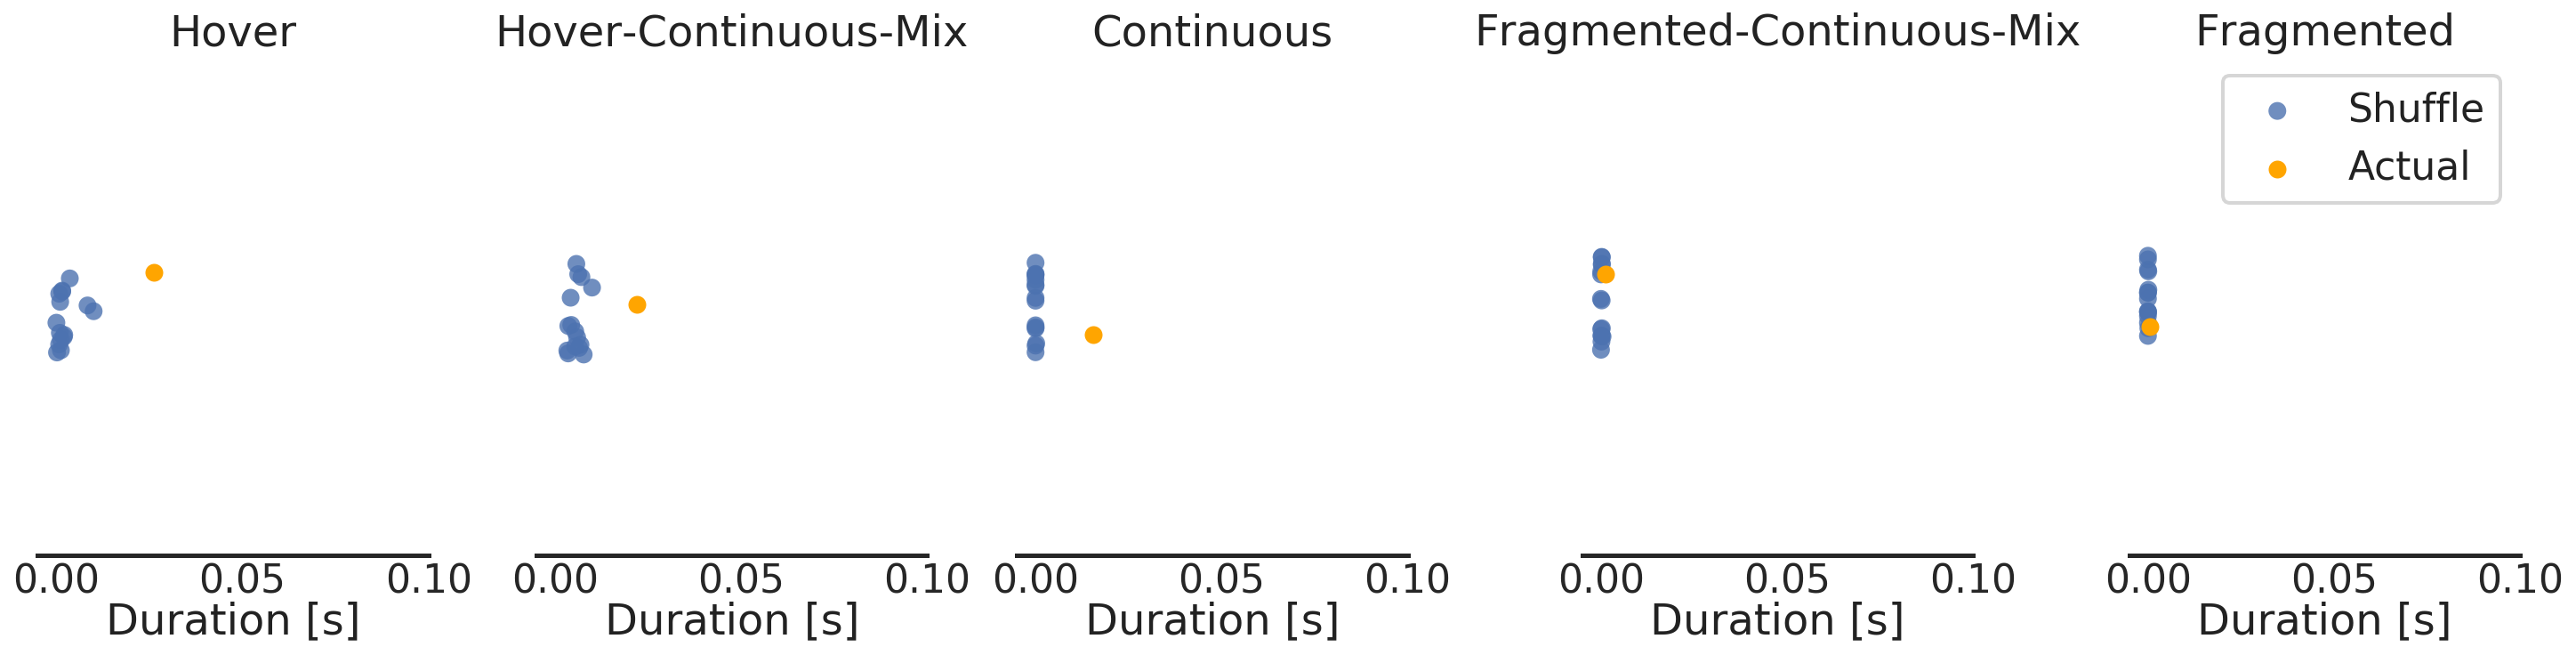

In [126]:
from src.parameters import STATE_ORDER

fig, axes = plt.subplots(1, len(STATE_ORDER), figsize=(20, 5),
                         constrained_layout=True, sharex=True, sharey=True)
for ax, state in zip(axes.ravel(), STATE_ORDER):
    plot_mean(f'{state}_duration', ax=ax)
    ax.set_title(state)
    ax.set_xlabel('Duration [s]')
ax.legend(['Shuffle', 'Actual'])
plt.xlim((-0.005, 0.100))

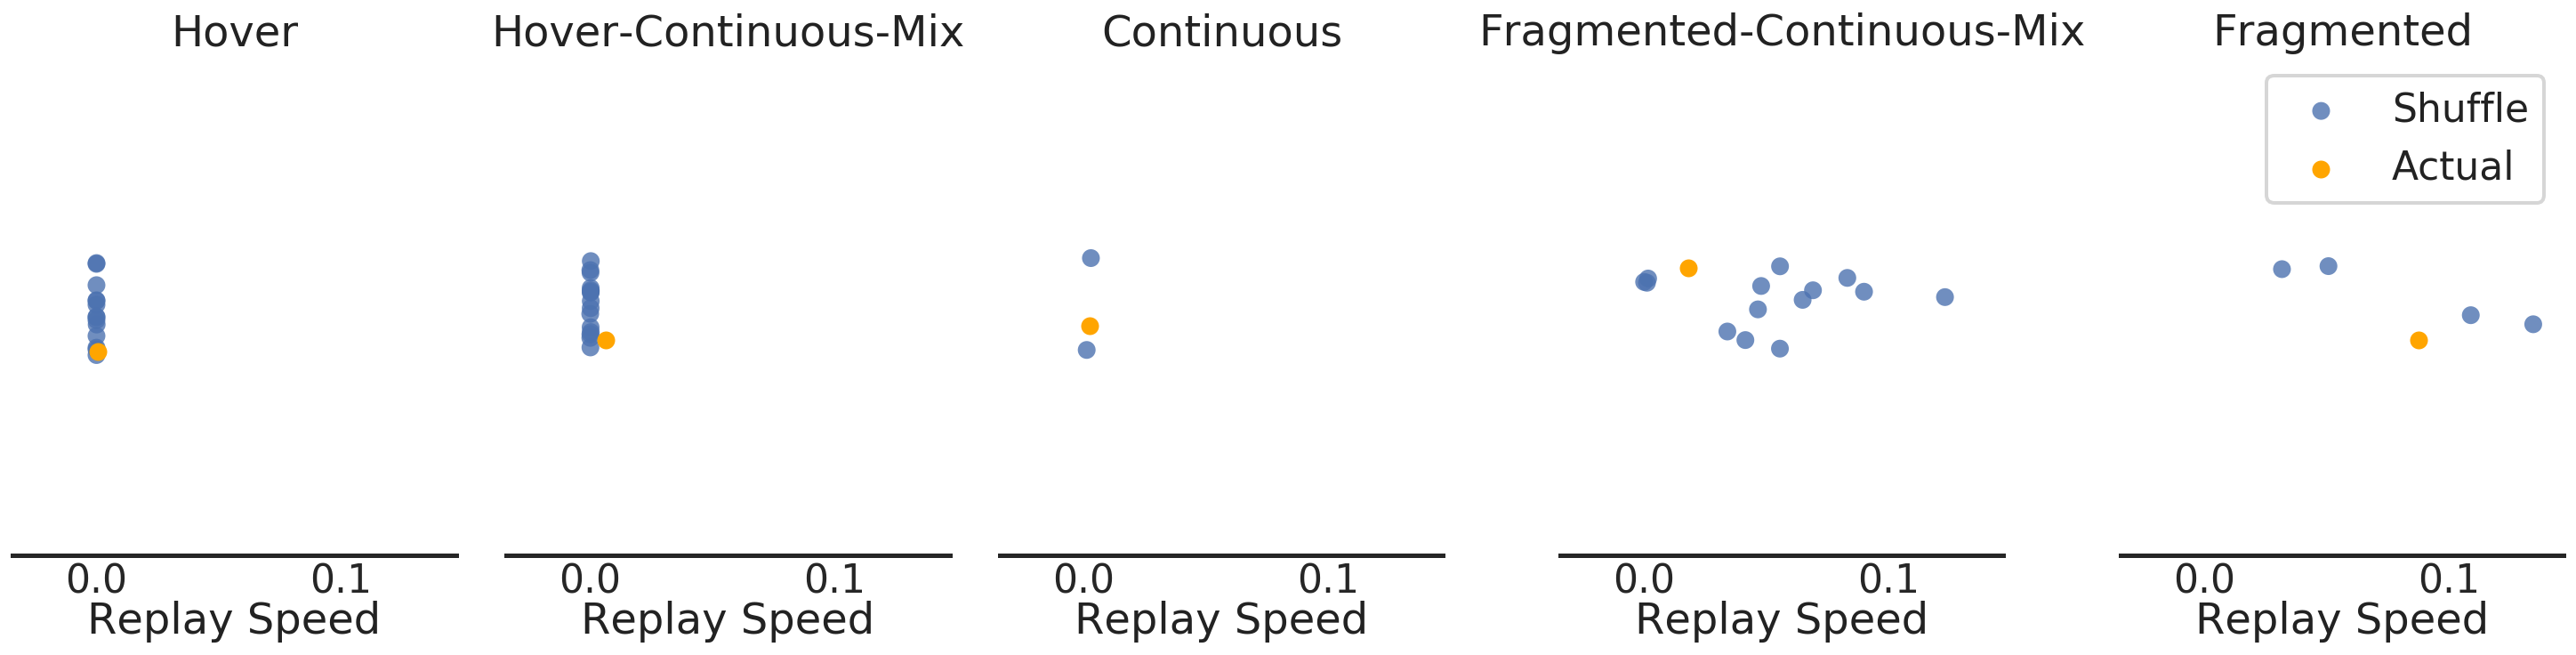

In [155]:
from src.parameters import STATE_ORDER

fig, axes = plt.subplots(1, len(STATE_ORDER), figsize=(20, 5),
                         constrained_layout=True, sharex=True, sharey=True)
for ax, state in zip(axes.ravel(), STATE_ORDER):
    plot_mean(f'{state}_replay_speed', ax=ax)
    ax.set_title(state)
    ax.set_xlabel('Replay Speed')
axes[-1].legend(['Shuffle', 'Actual'])
# plt.xlim((0, 1));

In [8]:
replay_info.is_classified.mean()

0.15542635658914727

In [115]:
shuffle_ind = 3
shuffle_result = xr.open_dataset('../Processed-Data/remy_35_02.nc',
                                 group=f"/{data_type}/{dim}/classifier/shuffle/shuffle_{shuffle_ind:02d}")
actual_result = xr.open_dataset('../Processed-Data/remy_35_02.nc',
                                 group=f"/{data_type}/{dim}/classifier/shuffle/actual")

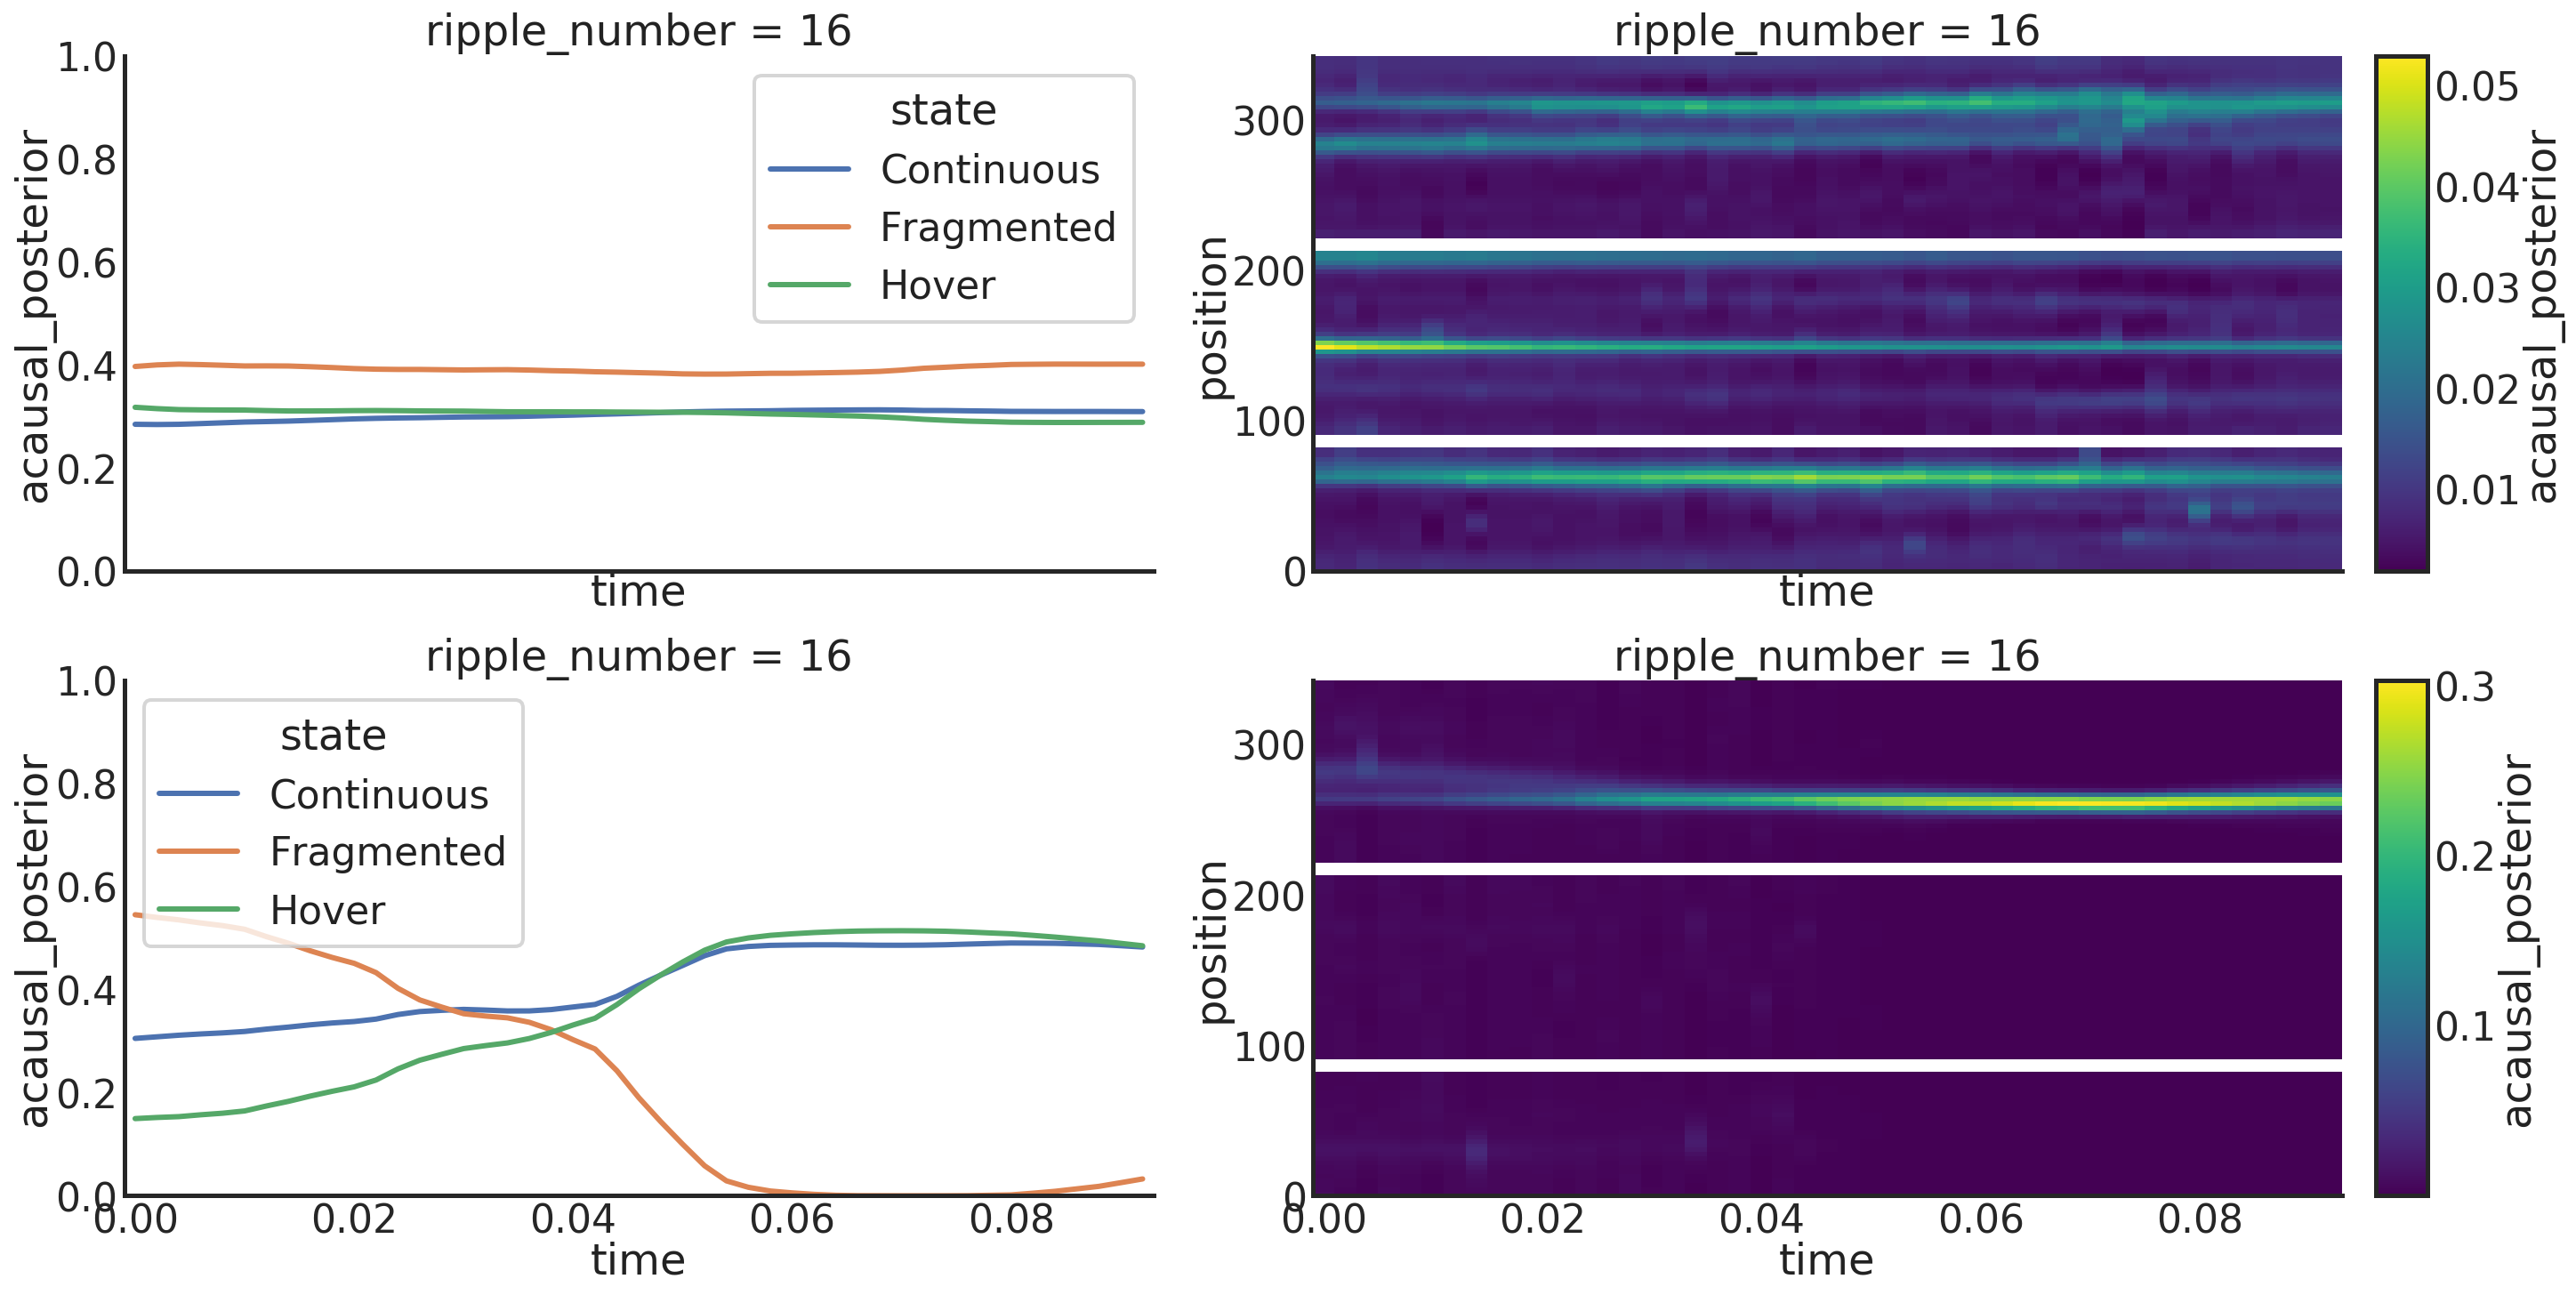

In [120]:
import seaborn as sns

ripple_number = 16

fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=True, constrained_layout=True)

posterior = shuffle_result.sel(ripple_number=ripple_number).acausal_posterior.dropna('time', how='all').assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
posterior.sum('position').plot(x='time', hue='state', ax=axes[0, 0])
axes[0, 0].set_ylim((0, 1))

posterior.sum('state', skipna=False).plot(x='time', y='position', ax=axes[0, 1])

# actual
posterior = actual_result.sel(ripple_number=ripple_number).acausal_posterior.dropna('time', how='all').assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
posterior.sum('position').plot(x='time', hue='state', ax=axes[1, 0])
axes[1, 0].set_ylim((0, 1))

posterior.sum('state', skipna=False).plot(x='time', y='position', ax=axes[1, 1])
sns.despine()

In [94]:

actual_result

<xarray.Dataset>
Dimensions:            (position: 109, ripple_number: 344, state: 3, time: 132)
Coordinates:
  * state              (state) object 'Continuous' 'Fragmented' 'Hover'
  * time               (time) timedelta64[ns] 00:00:00 ... 00:00:00.262000
  * position           (position) float64 1.464 4.391 7.319 ... 338.4 341.3
  * ripple_number      (ripple_number) int64 1 2 3 4 5 6 ... 340 341 342 343 344
Data variables:
    acausal_posterior  (ripple_number, time, state, position) float64 ...

In [ ]:
ripple_number = 150

fig, axes = plt.subplots(1, 2, figsize=(25, 5))
posterior = shuffle_result.sel(ripple_number=ripple_number).acausal_posterior.dropna('time', how='all').assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))

posterior.sum('position').plot(x='time', hue='state', ax=axes[0])
axes[0].set_ylim((0, 1))

posterior.sum('state', skipna=False).plot(x='time', y='position', ax=axes[1])

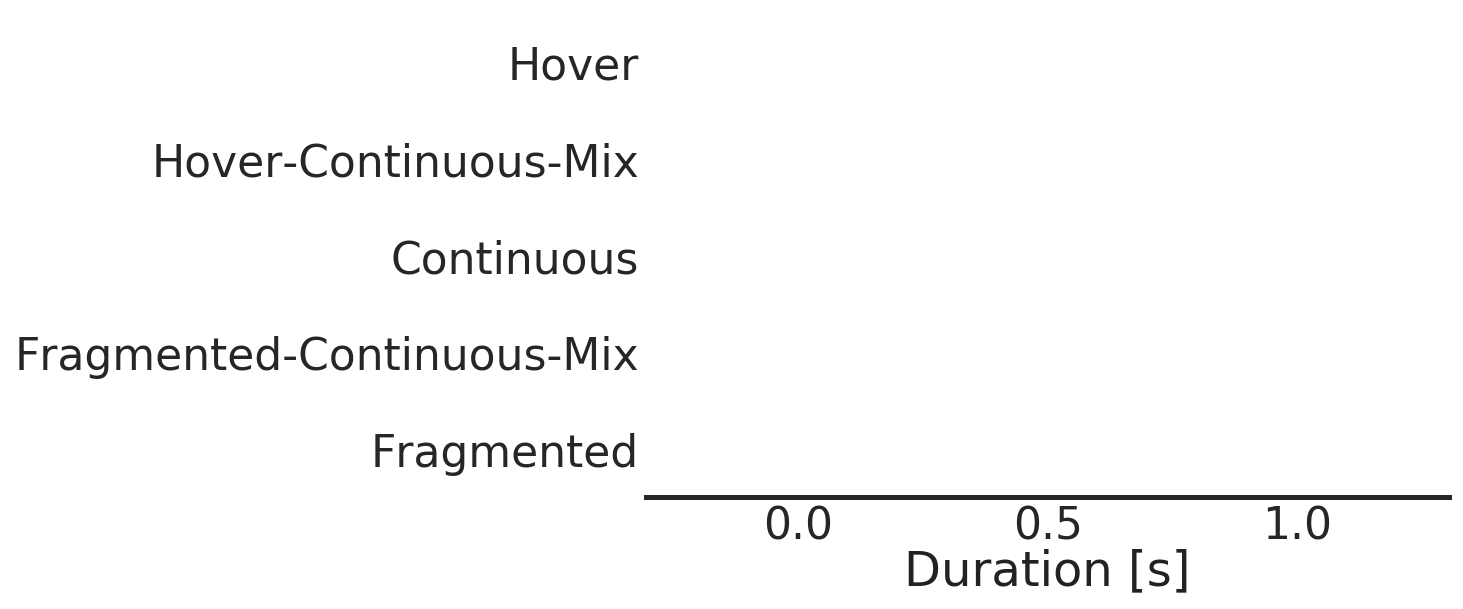

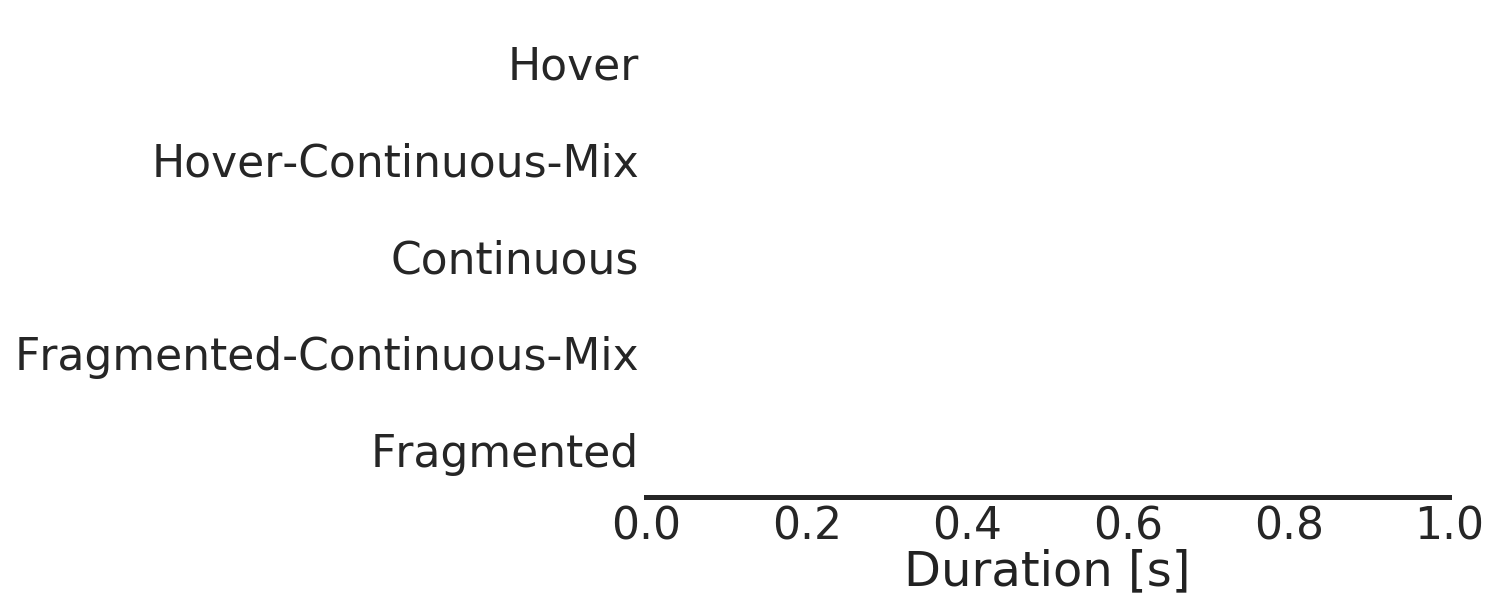

In [18]:
from src.visualization import plot_category_duration

plt.figure()
plot_category_duration(replay_info)

plt.figure()
plot_category_duration(replay_info, kind='violin')

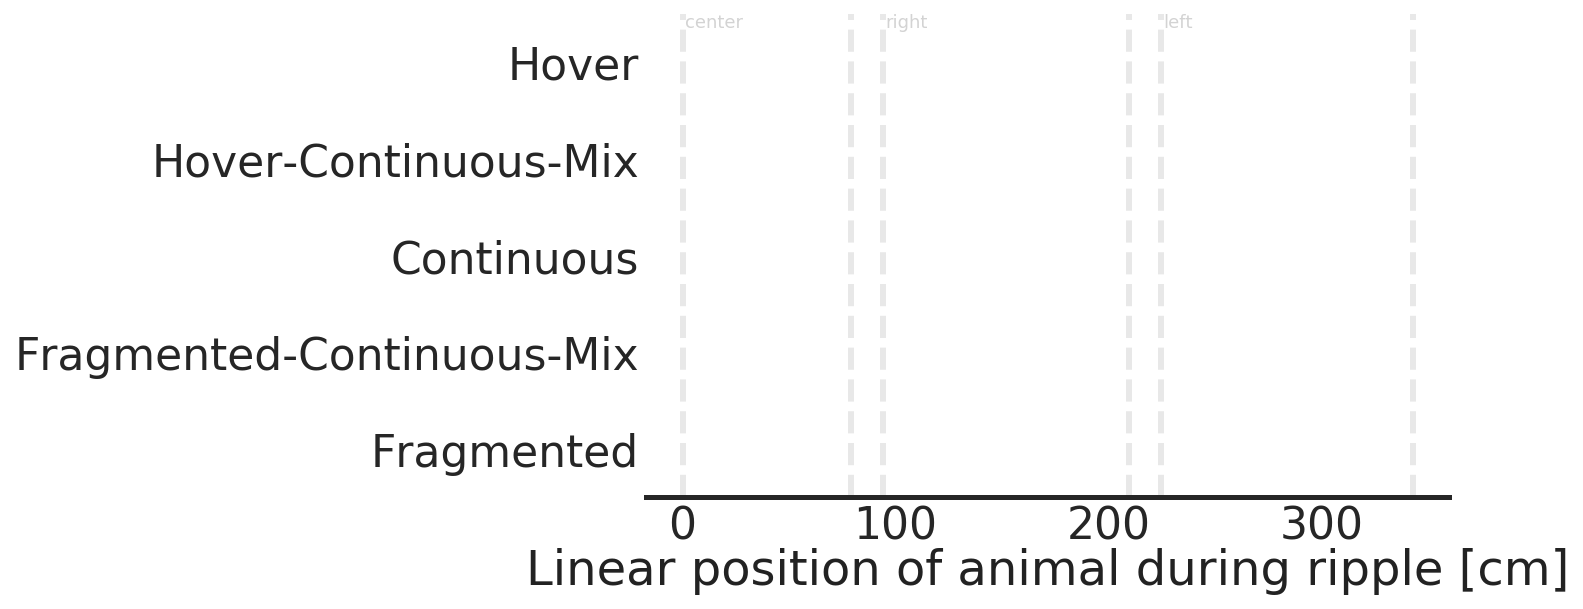

In [12]:
from src.visualization import plot_linear_position_of_animal

plot_linear_position_of_animal(replay_info)

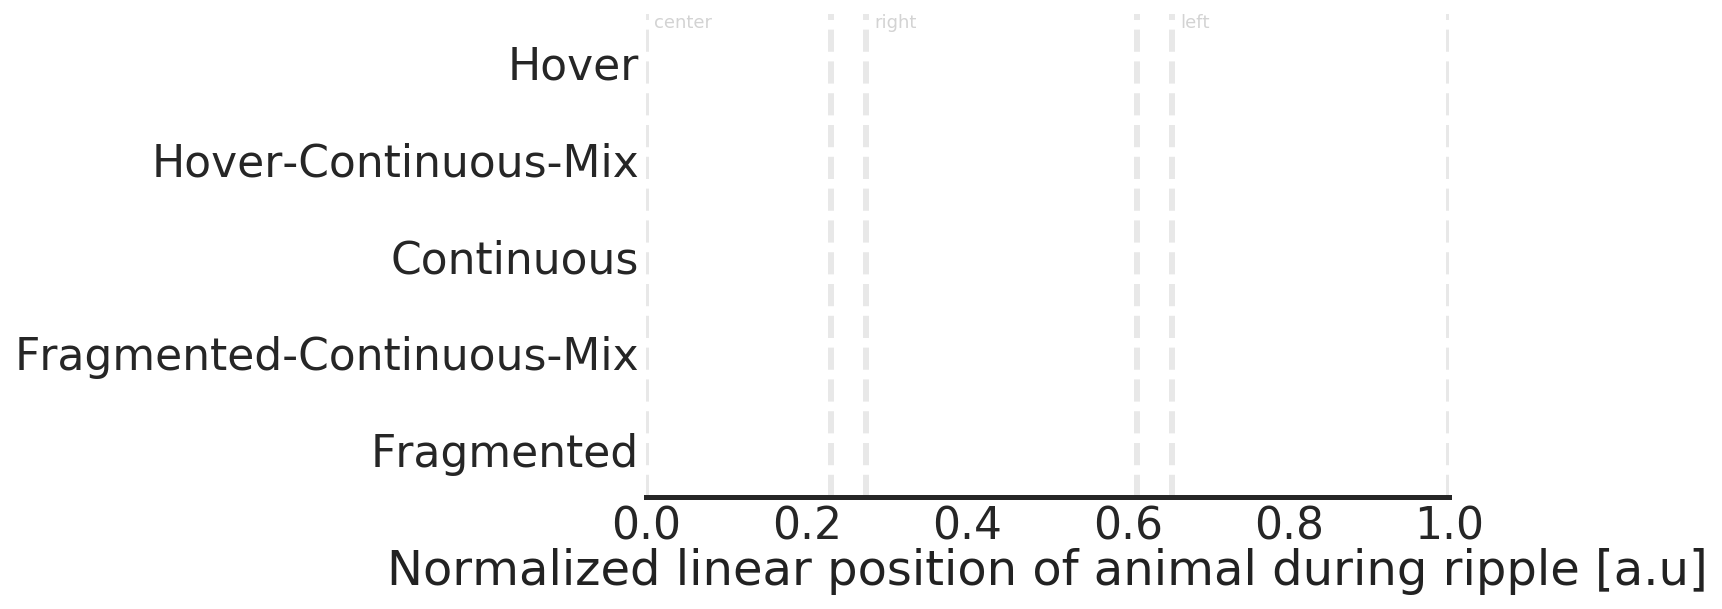

In [13]:
from src.visualization import plot_normalized_linear_position_of_animal

plot_normalized_linear_position_of_animal(replay_info)

KeyError: "None of [Index(['Hover', 'Hover-Continuous-Mix', 'Continuous',\n       'Fragmented-Continuous-Mix', 'Fragmented'],\n      dtype='object')] are in the [columns]"

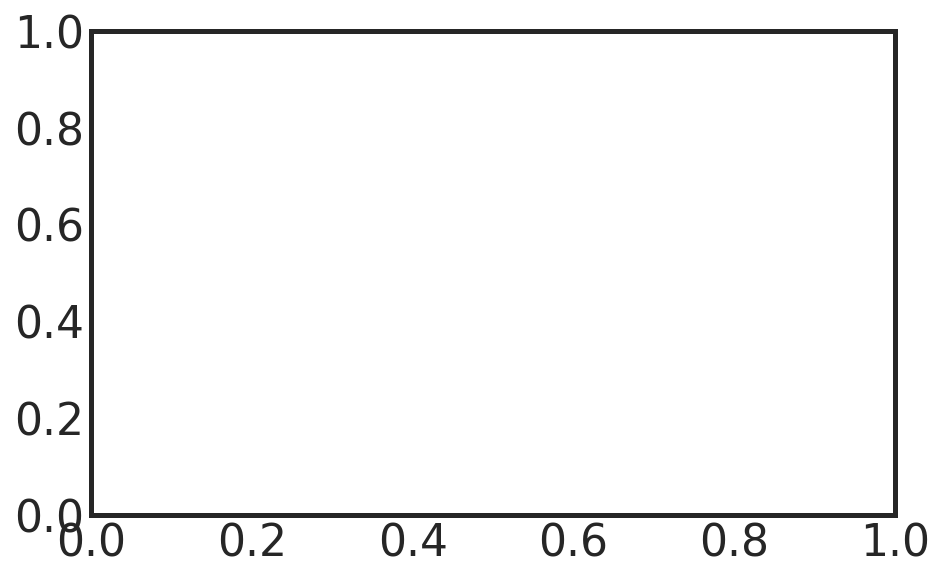

In [14]:
from src.visualization import plot_replay_distance_from_actual_position

plt.figure()
plot_replay_distance_from_actual_position(replay_info)

plt.figure()
plot_replay_distance_from_actual_position(replay_info, kind='violin', bw=0.1)

KeyError: "None of [Index(['Hover', 'Hover-Continuous-Mix', 'Continuous',\n       'Fragmented-Continuous-Mix', 'Fragmented'],\n      dtype='object')] are in the [columns]"

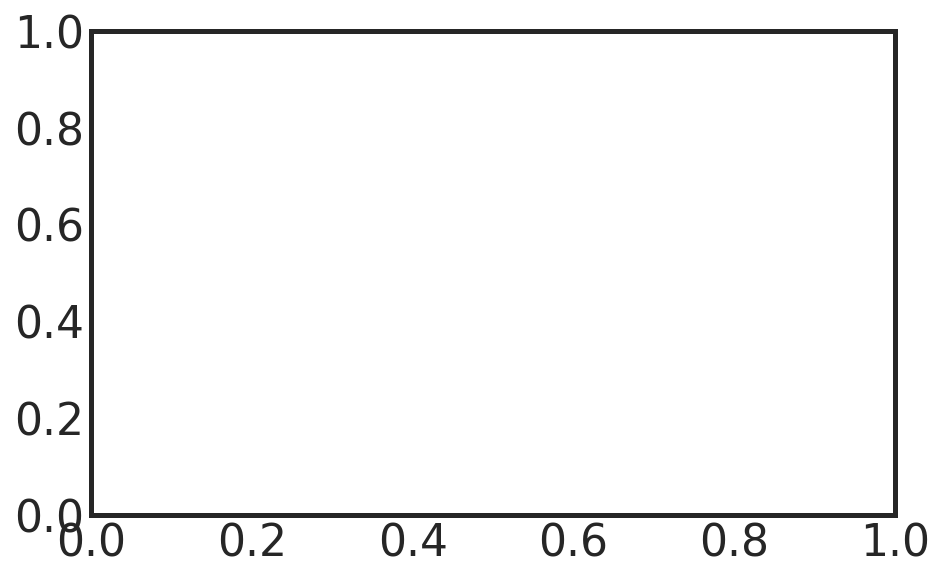

In [15]:
from src.visualization import plot_replay_total_distance

plt.figure()
plot_replay_total_distance(replay_info)

plt.figure()
plot_replay_total_distance(replay_info, kind='violin', bw=0.1)

KeyError: "None of [Index(['Hover', 'Hover-Continuous-Mix', 'Continuous',\n       'Fragmented-Continuous-Mix', 'Fragmented'],\n      dtype='object')] are in the [columns]"

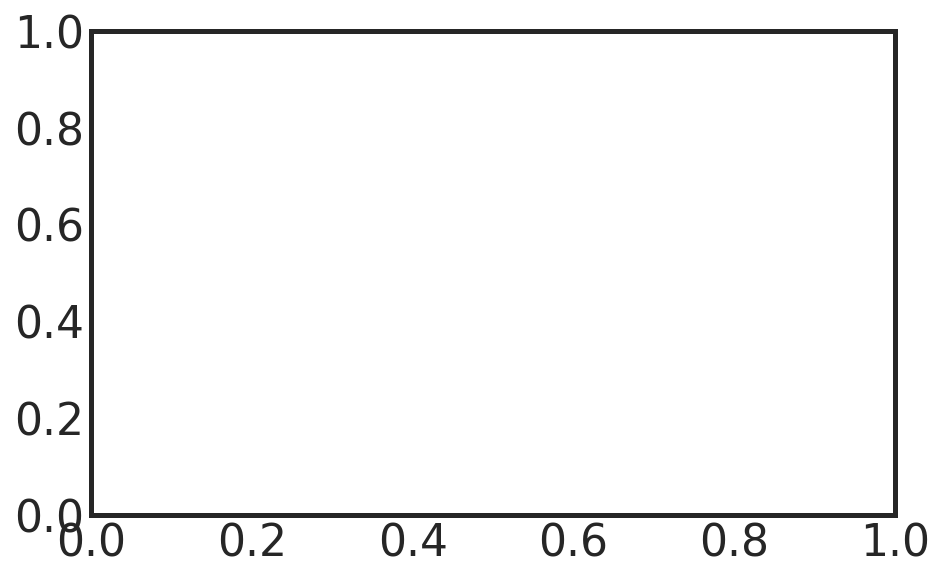

In [16]:
from src.visualization import plot_replay_total_displacement

plt.figure()
plot_replay_total_displacement(replay_info, kind='strip')


plt.figure()
plot_replay_total_displacement(replay_info, kind='violin', bw=0.1)

plt.figure()
plot_replay_total_displacement(replay_info, kind='violin', bw=0.1)
plt.gca().set_xscale('log')

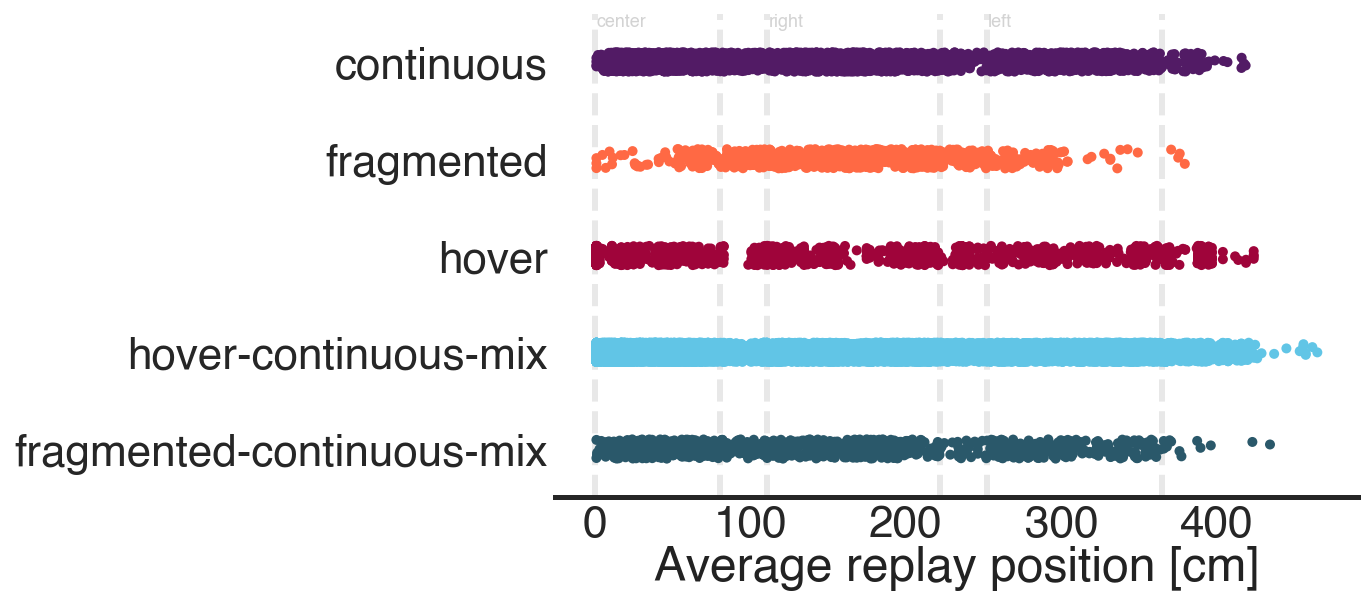

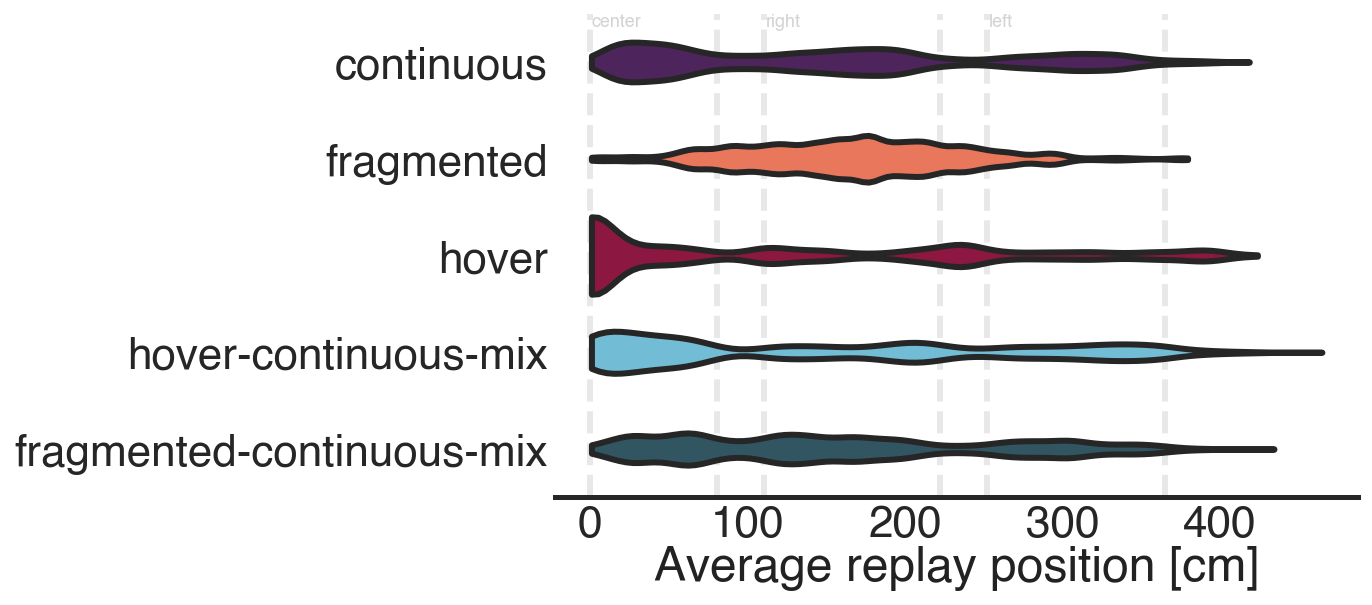

In [14]:
from src.visualization import plot_replay_linear_position

plt.figure()
plot_replay_linear_position(replay_info)

plt.figure()
plot_replay_linear_position(replay_info, kind='violin', bw=0.1, inner=None)

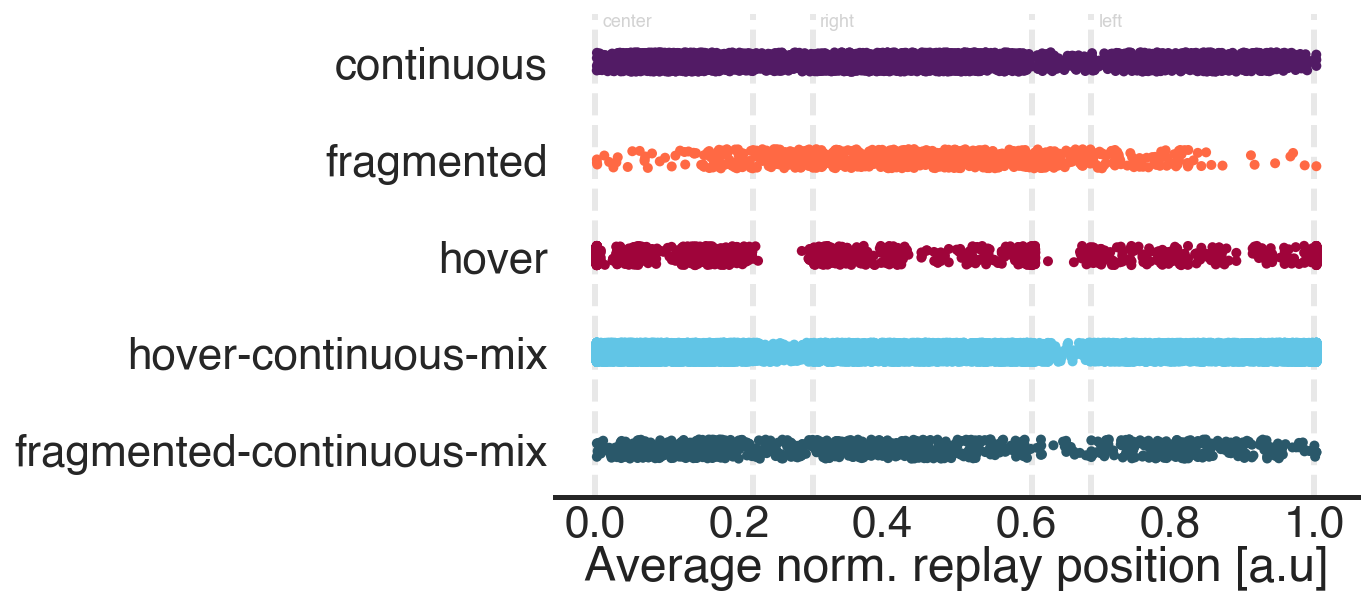

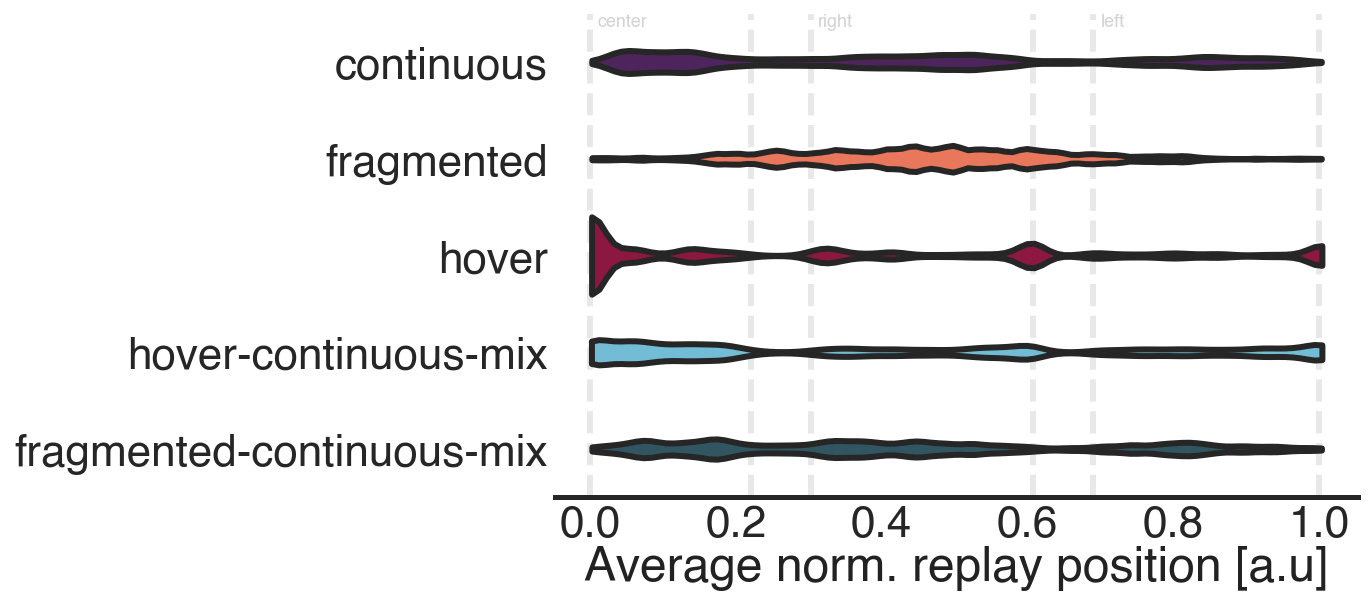

In [15]:
from src.visualization import plot_replay_norm_linear_position

plt.figure()
plot_replay_norm_linear_position(replay_info)

plt.figure()
plot_replay_norm_linear_position(replay_info, kind='violin', bw=0.05, inner=None)

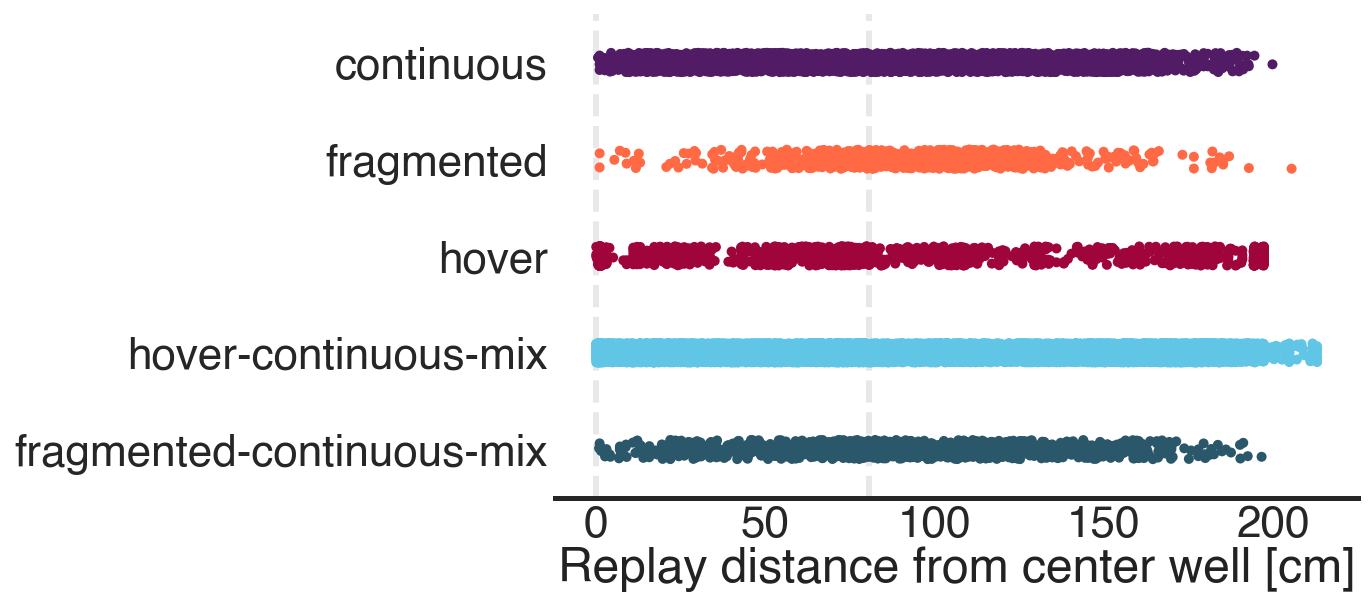

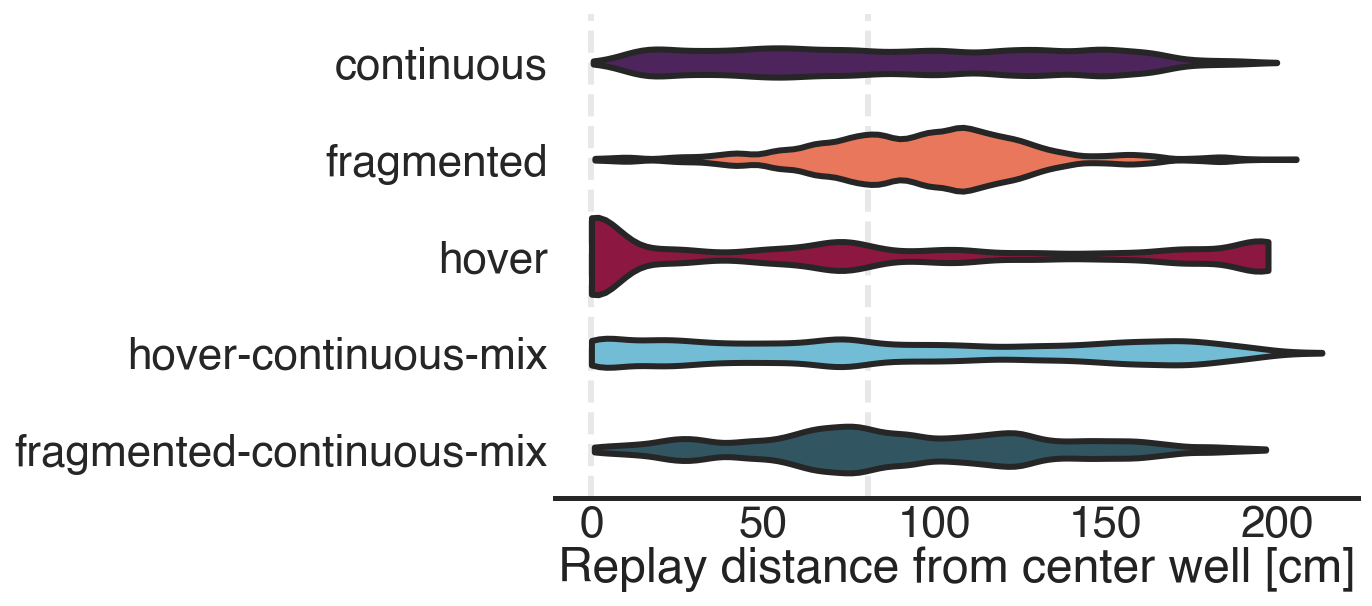

In [16]:
from src.visualization import plot_replay_distance_from_center_well

plt.figure()
plot_replay_distance_from_center_well(replay_info)

plt.figure()
plot_replay_distance_from_center_well(replay_info, kind='violin', bw=0.1, inner=None)

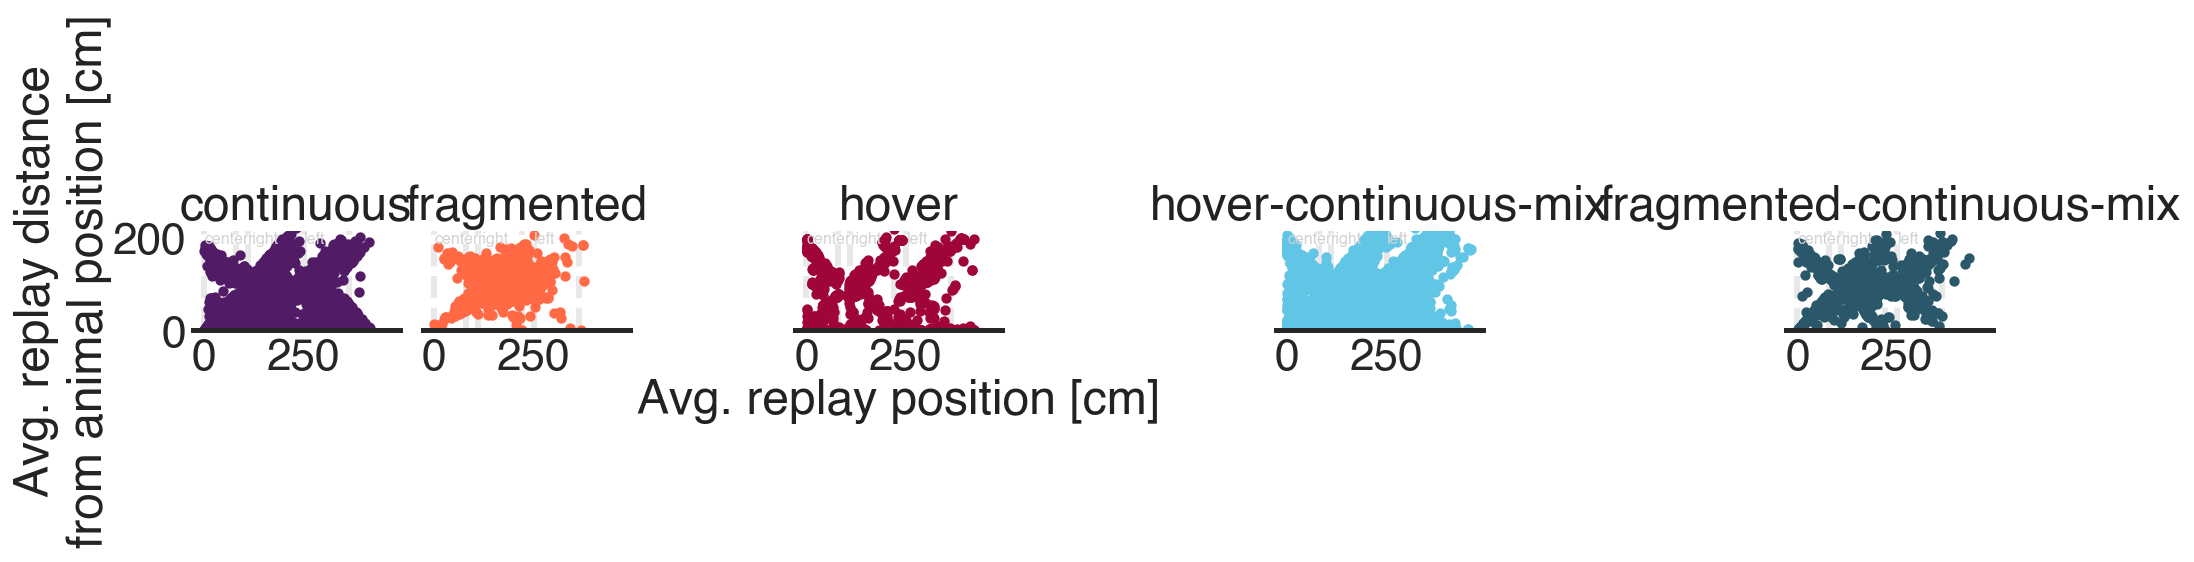

In [17]:
from src.visualization import plot_replay_linear_position_vs_distance_from_actual_position

plot_replay_linear_position_vs_distance_from_actual_position(replay_info)

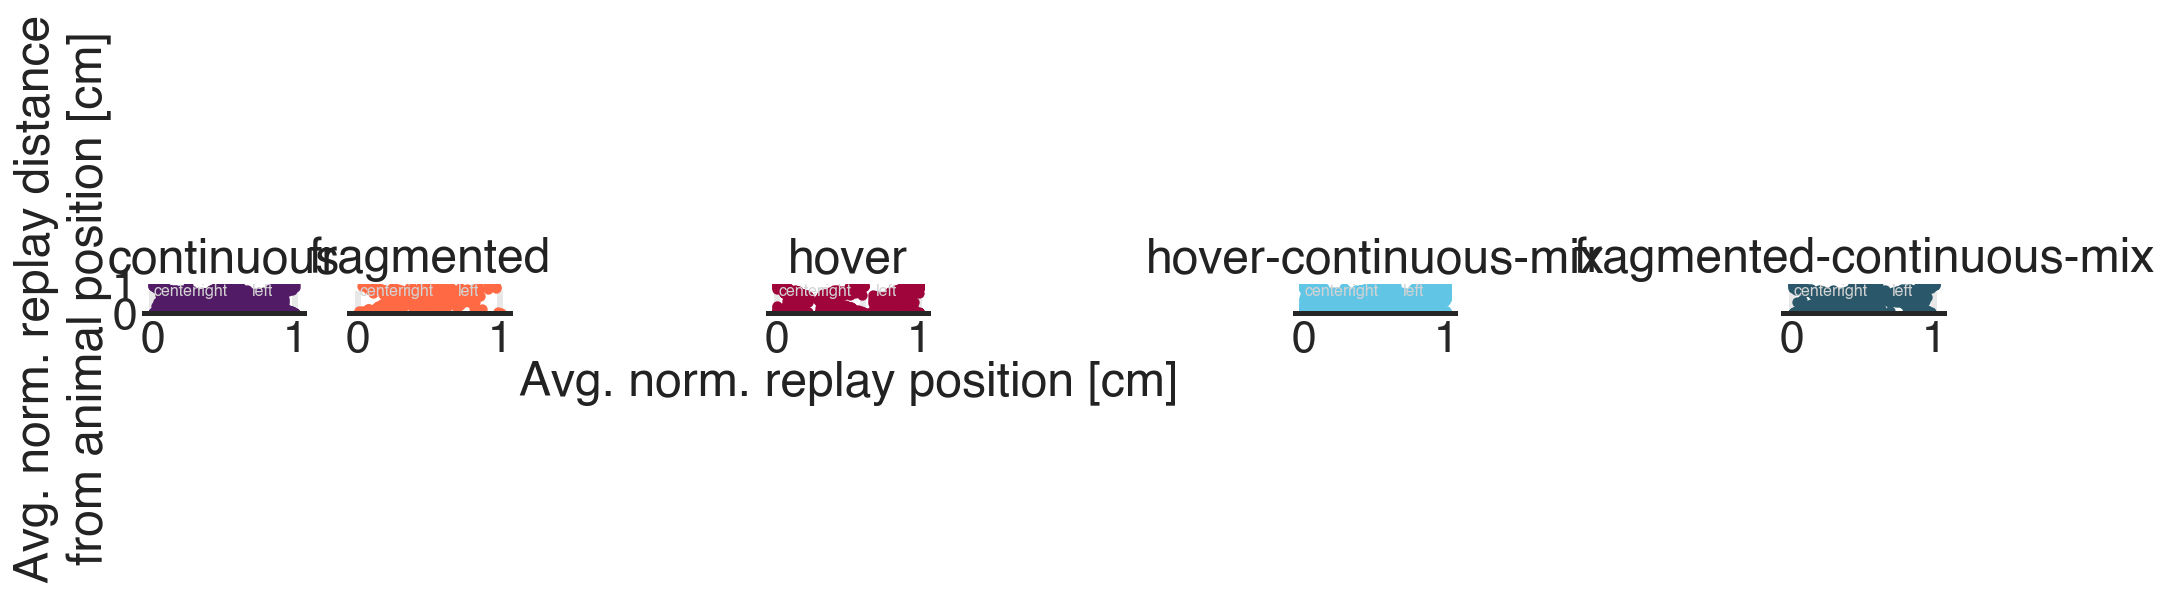

In [18]:
from src.visualization import plot_norm_replay_linear_position_vs_distance_from_actual_position

plot_norm_replay_linear_position_vs_distance_from_actual_position(replay_info)

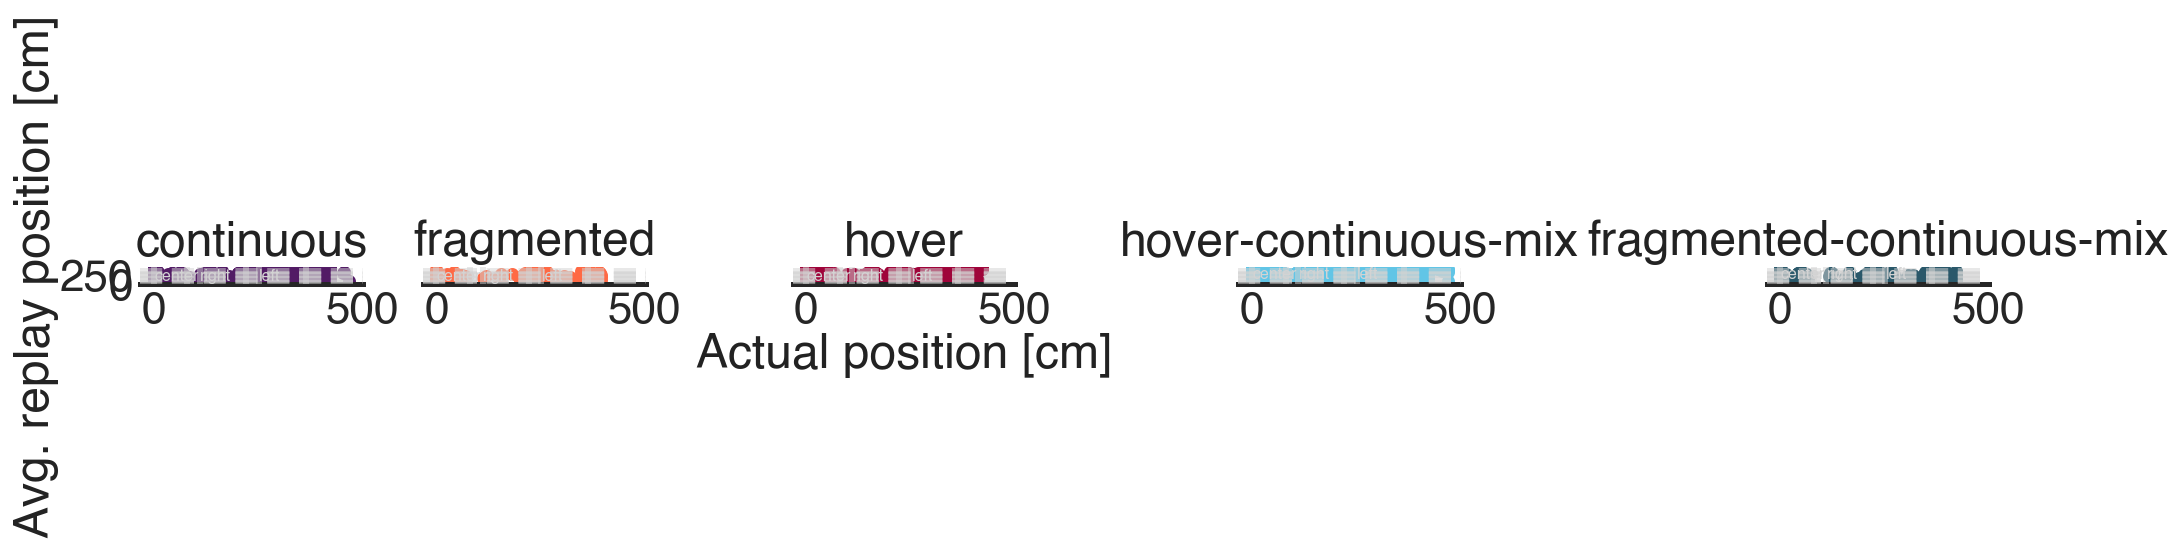

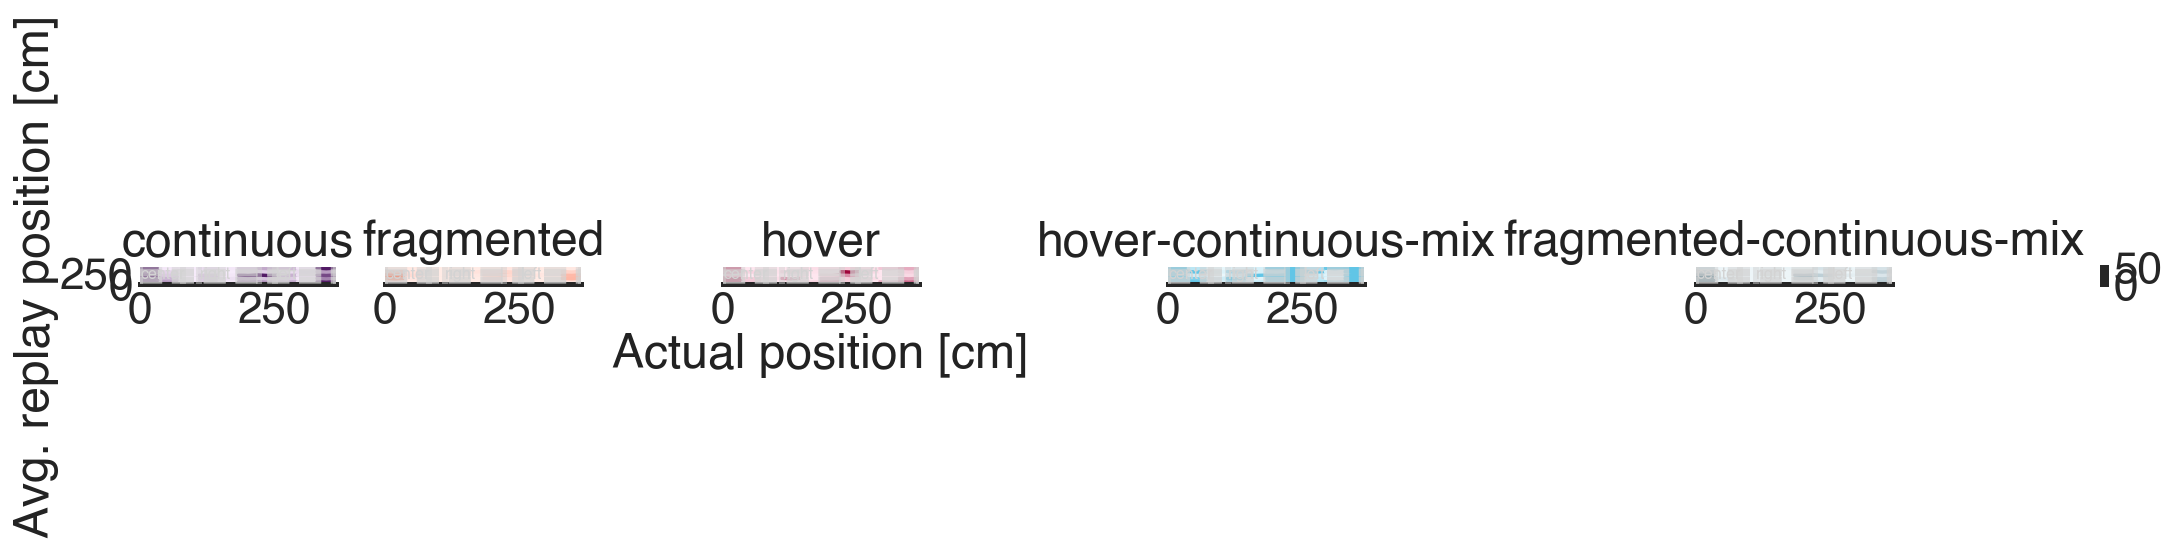

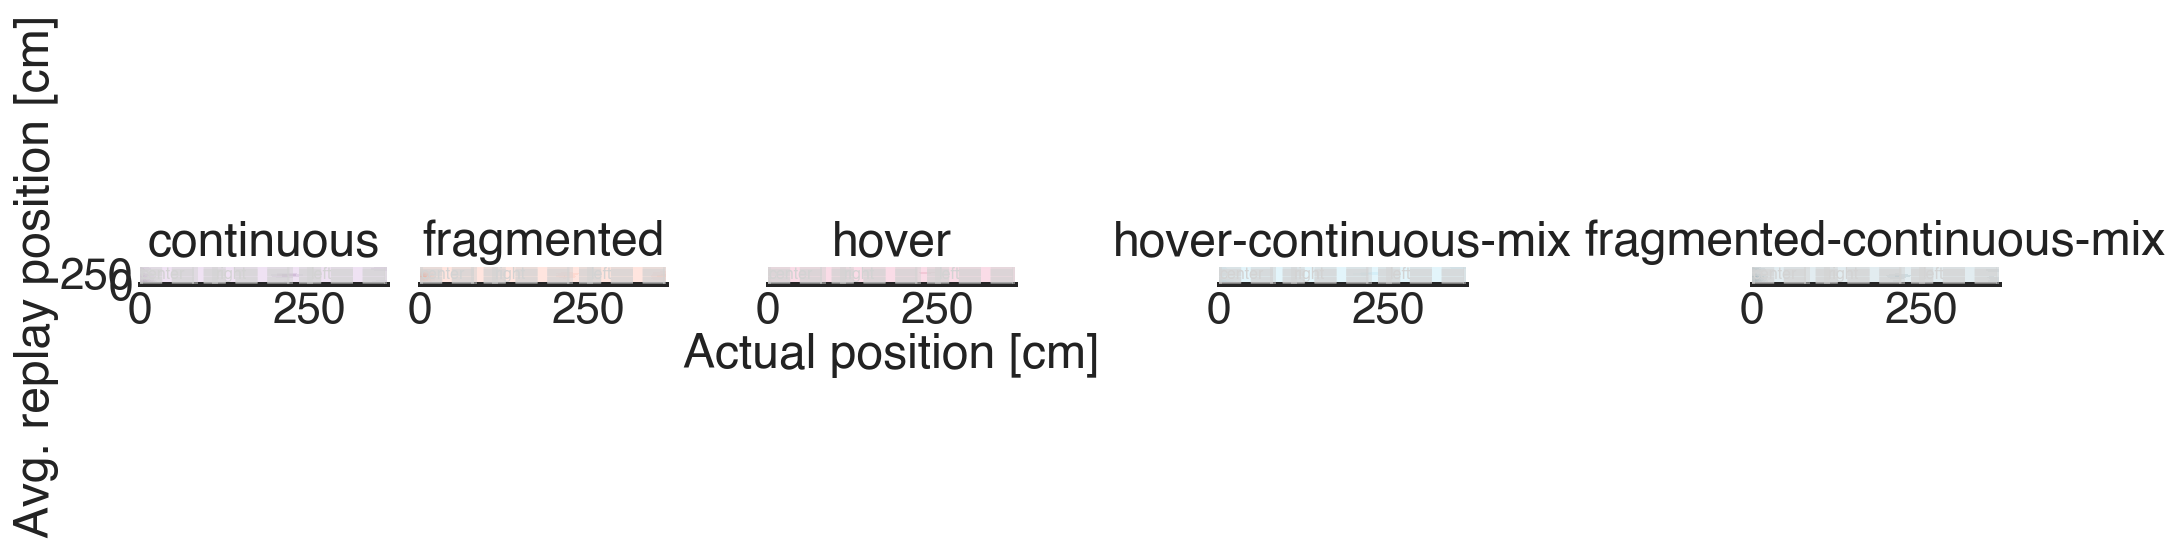

In [19]:
from src.visualization import plot_actual_position_vs_replay_position

plot_actual_position_vs_replay_position(replay_info)
plot_actual_position_vs_replay_position(replay_info, kind='hexbin', vmax=50)
plot_actual_position_vs_replay_position(replay_info, kind='kdeplot')

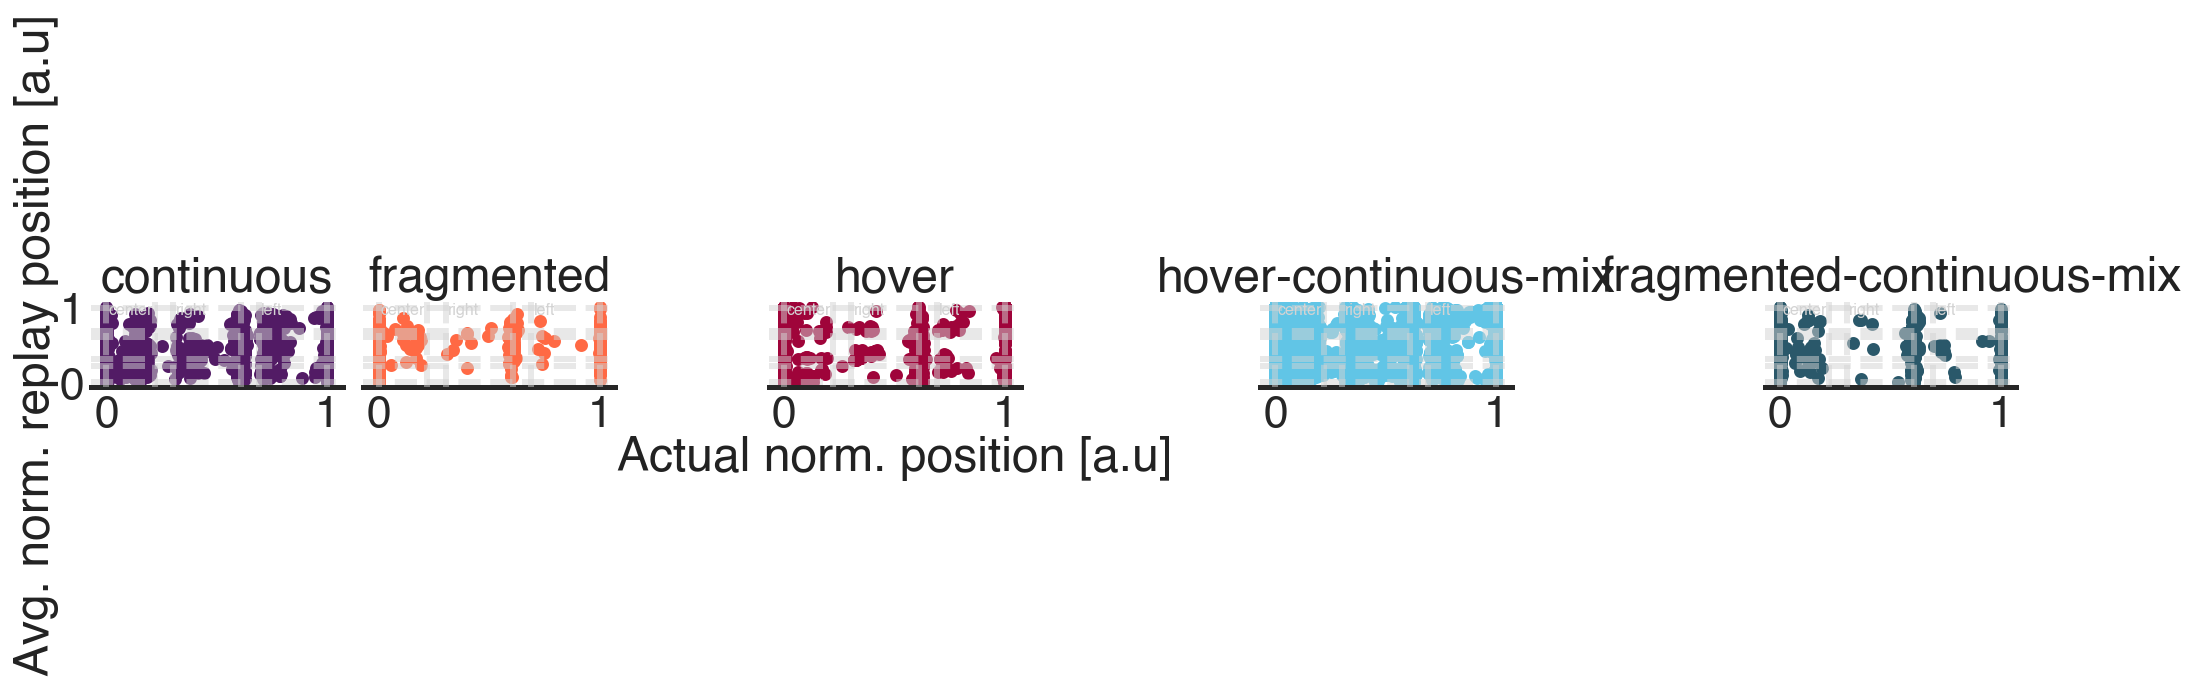

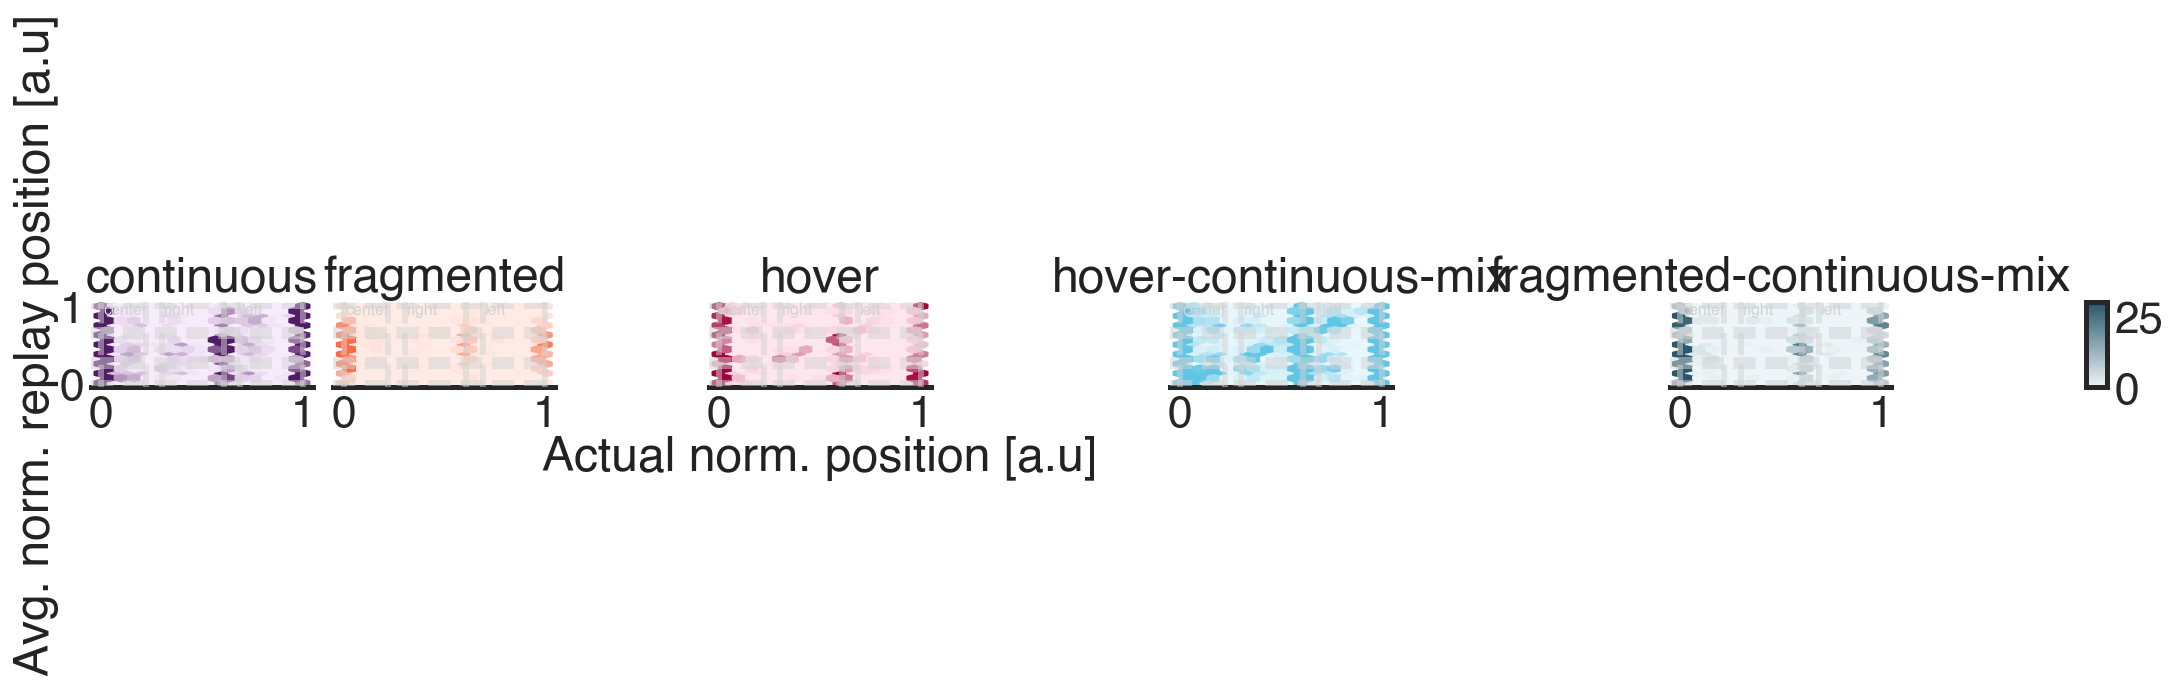

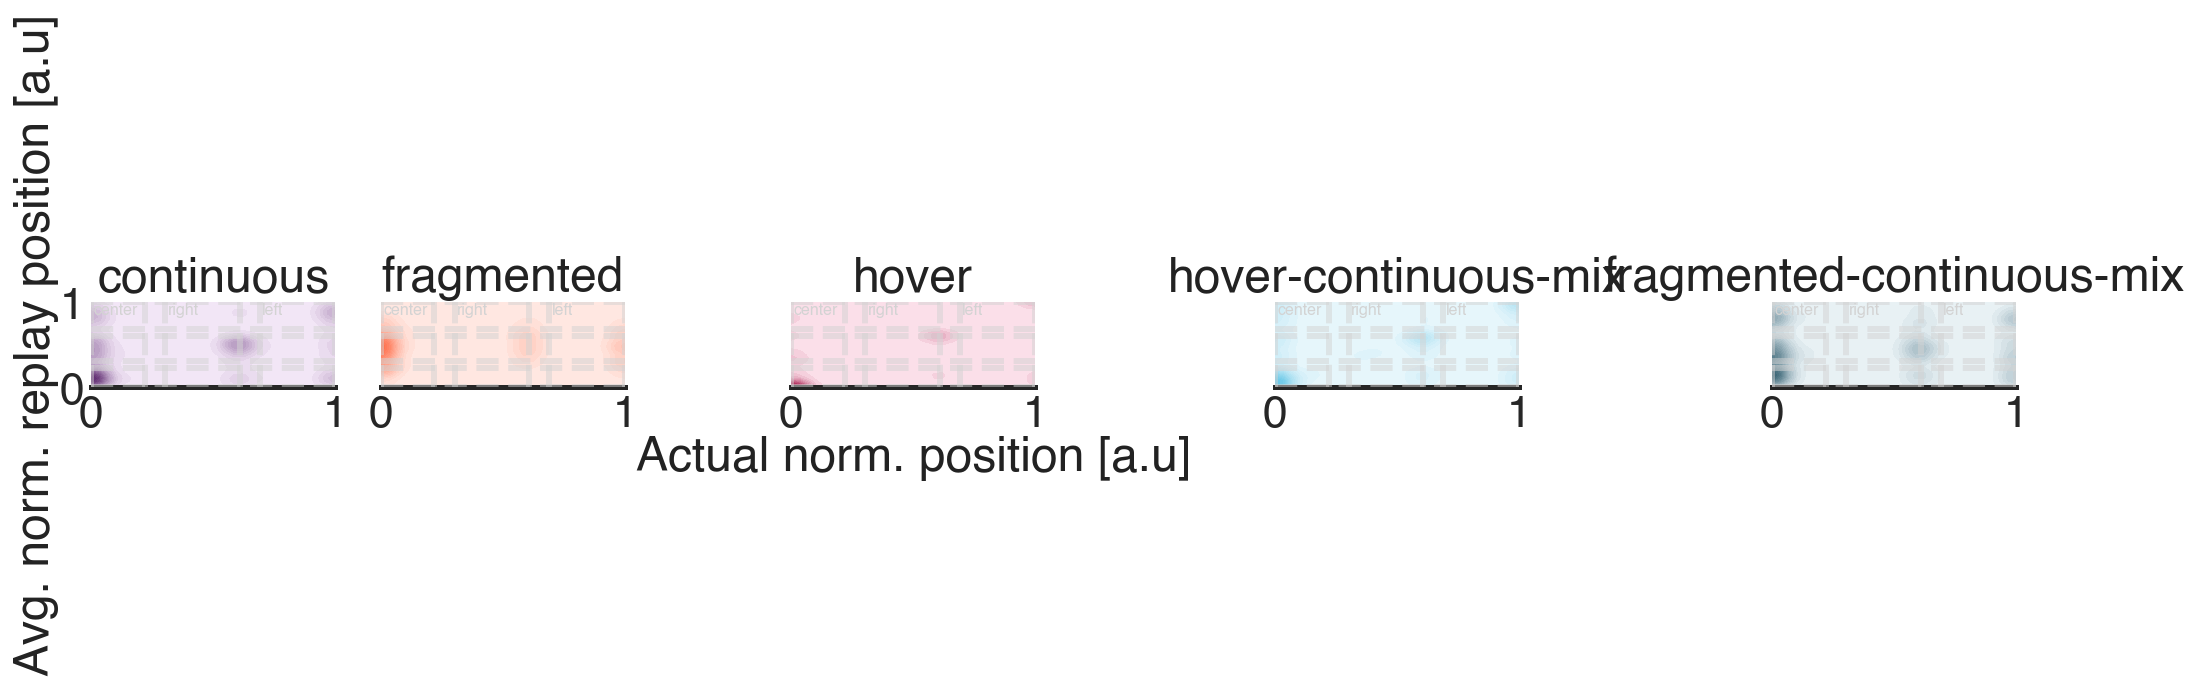

In [20]:
from src.visualization import plot_norm_actual_position_vs_replay_position

plot_norm_actual_position_vs_replay_position(replay_info)
plot_norm_actual_position_vs_replay_position(replay_info, kind='hexbin')
plot_norm_actual_position_vs_replay_position(replay_info, kind='kdeplot')

In [17]:
hovers = replay_info.loc[replay_info.hover]

plt.scatter(replay_info.hover_replay_linear_position.values,
            replay_info.hover_replay_distance_from_actual_position.values,
            c=STATE_COLORS['hover'], s=10)
plt.axis('square')
sns.despine()

AttributeError: 'DataFrame' object has no attribute 'hover'

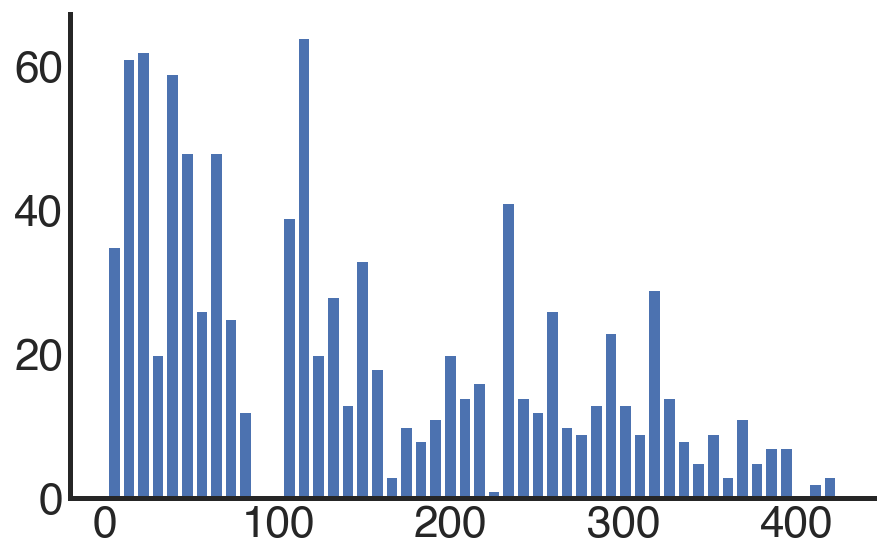

In [71]:
plt.hist(replay_info.loc[replay_info.hover_replay_distance_from_actual_position > 5].hover_replay_linear_position.values,
         bins=50)
sns.despine()

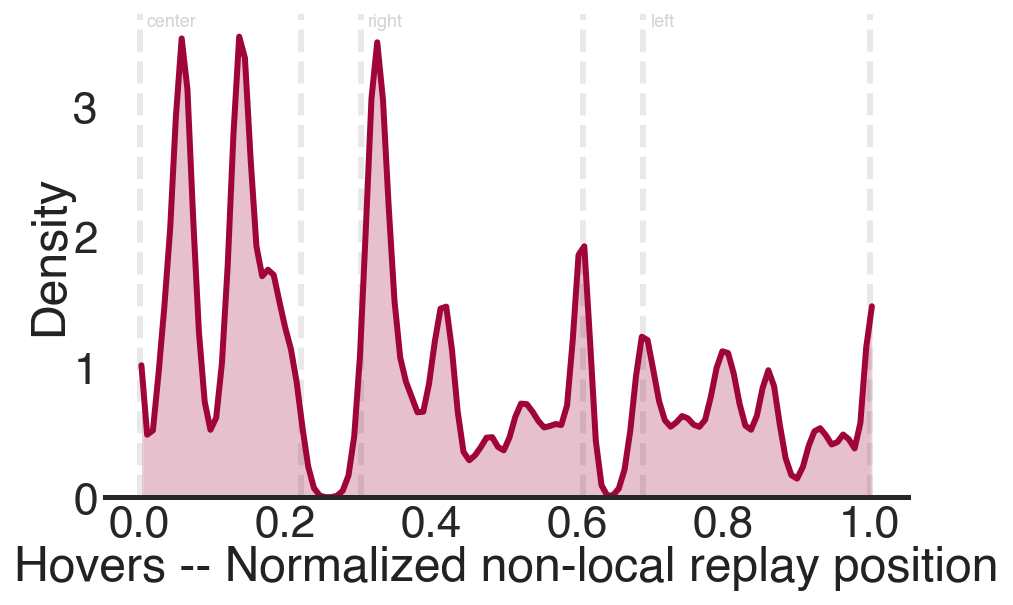

In [95]:
from src.visualization import plot_linear_position_markers

sns.kdeplot(norm_non_local_hover, bw=0.01, cut=0, shade=True,
            facecolor=STATE_COLORS['hover'], color=STATE_COLORS['hover'], legend=False)
plt.xlabel('Hovers -- Normalized non-local replay position')
plt.ylabel('Density')
plot_linear_position_markers(replay_info, is_normalized=True, jitter=0.01)
sns.despine(left=True)
save_figure('hovers_normalized_non_local_replay_position')

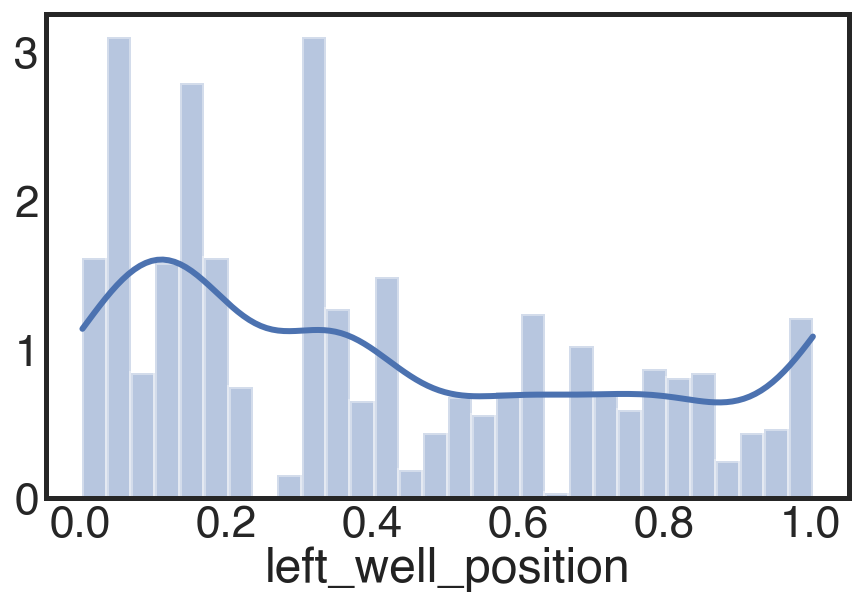

In [69]:
norm_non_local_hover = (
    replay_info.loc[replay_info.hover_replay_distance_from_actual_position > 5].hover_replay_linear_position.values /
    replay_info.loc[replay_info.hover_replay_distance_from_actual_position > 5].left_well_position)

sns.distplot(norm_non_local_hover, kde_kws=dict(cut=0), bins=30, norm_hist=True)


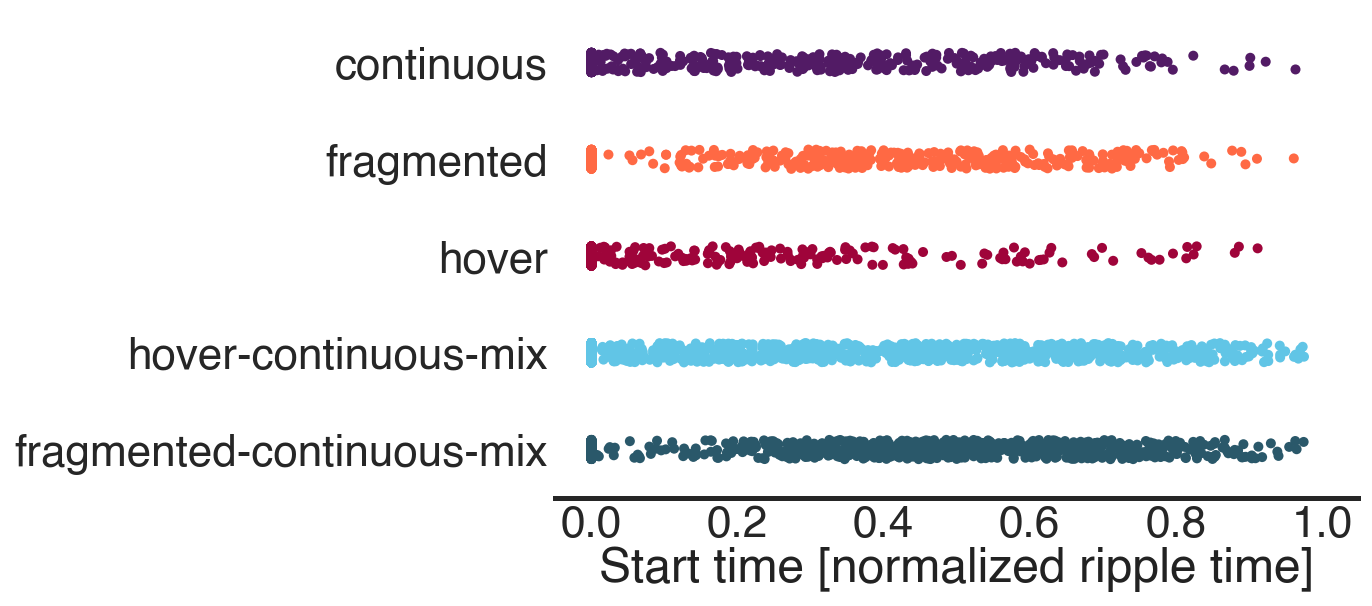

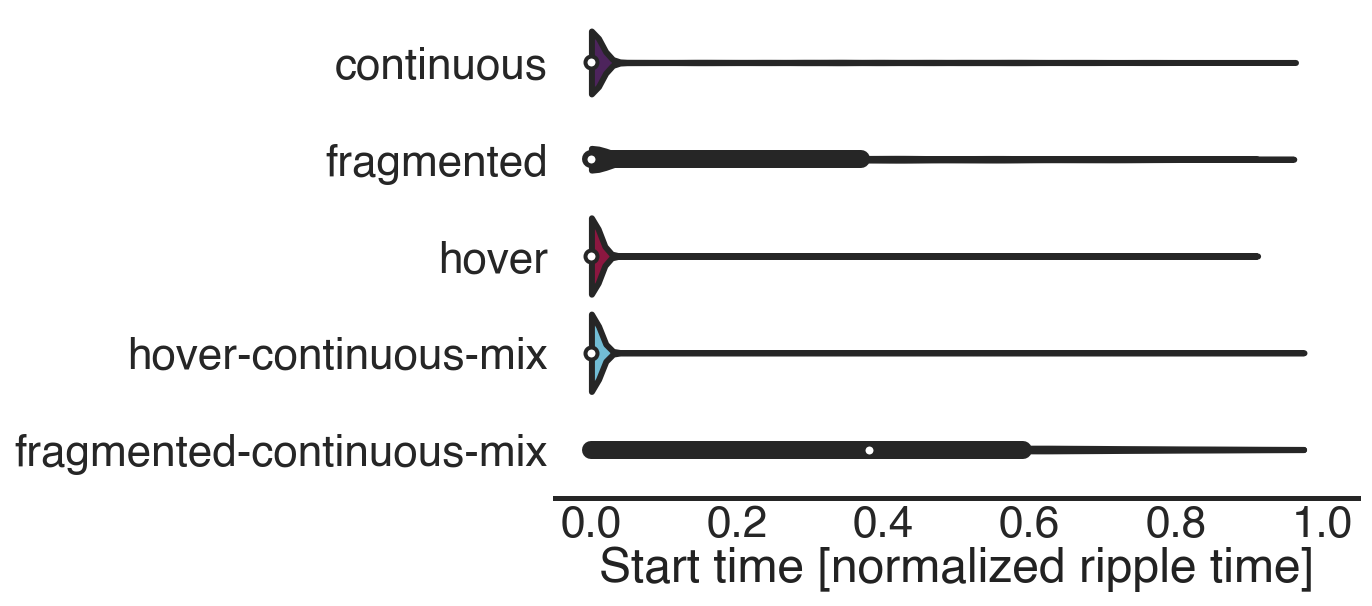

In [21]:
from src.visualization import plot_replay_time


plt.figure()
plot_replay_time(replay_info)

plt.figure()
plot_replay_time(replay_info, kind='violin', bw=0.1)
save_figure('start_time')

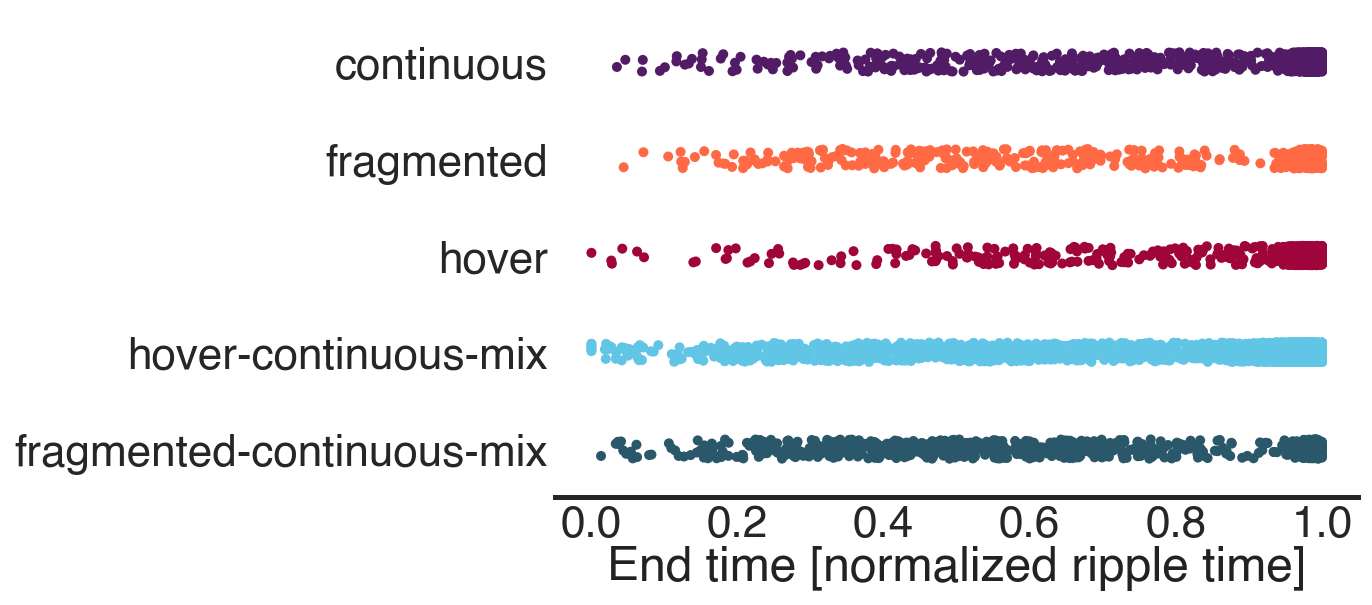

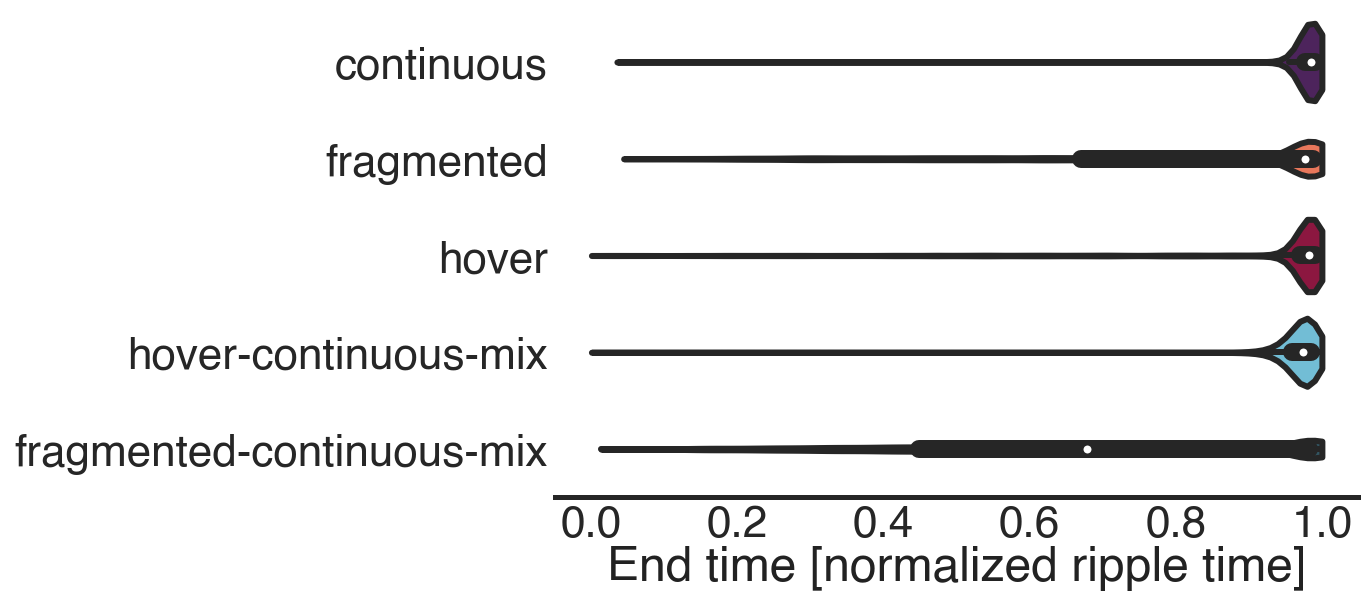

In [22]:
from src.visualization import plot_replay_time


plt.figure()
plot_replay_time(replay_info, is_min=False)

plt.figure()
plot_replay_time(replay_info, is_min=False, kind='violin', bw=0.1)
save_figure('end_time')

In [1]:
from src.visualization import plot_replay_speed


plt.figure()
plot_replay_speed(replay_info, kind='violin')
plt.gca().set_xscale('log')
plt.xlim((1E-4, 1E4))
save_figure('replay_speed')

plt.figure()
plot_replay_speed(replay_info, kind='violin')
plt.xlim((-0.001, 50));
save_figure('replay_speed2')

NameError: name 'plt' is not defined

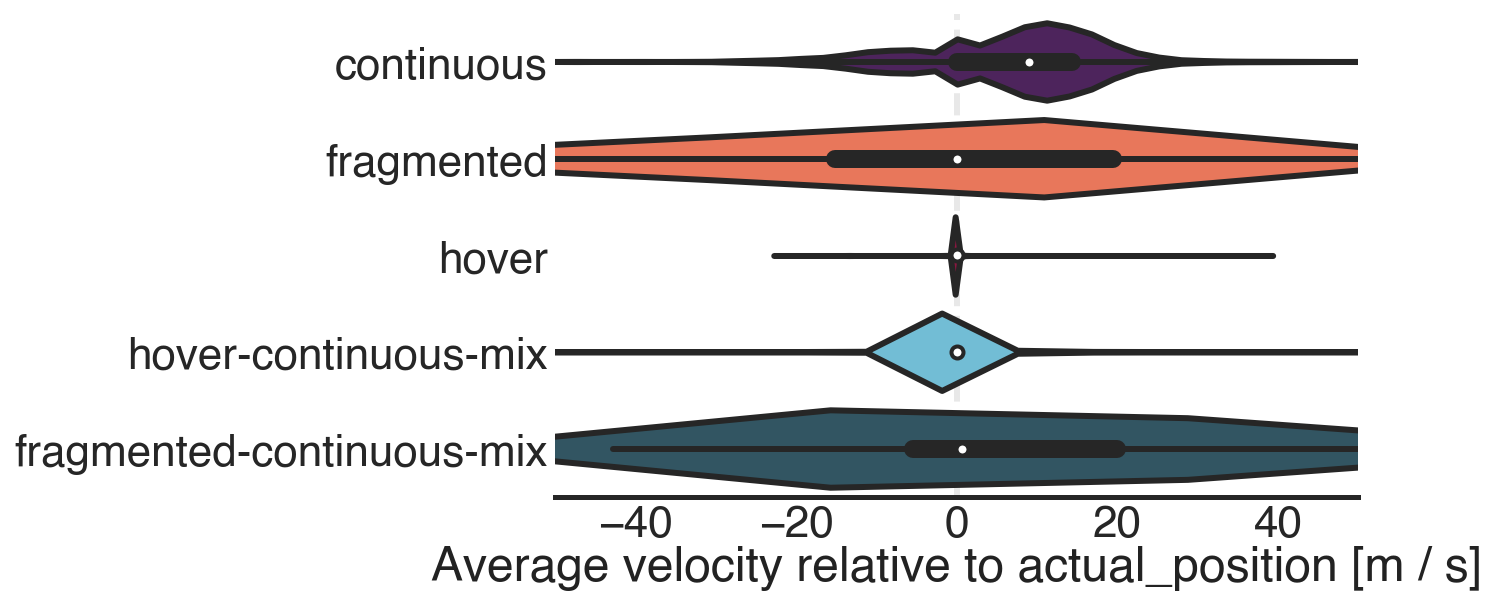

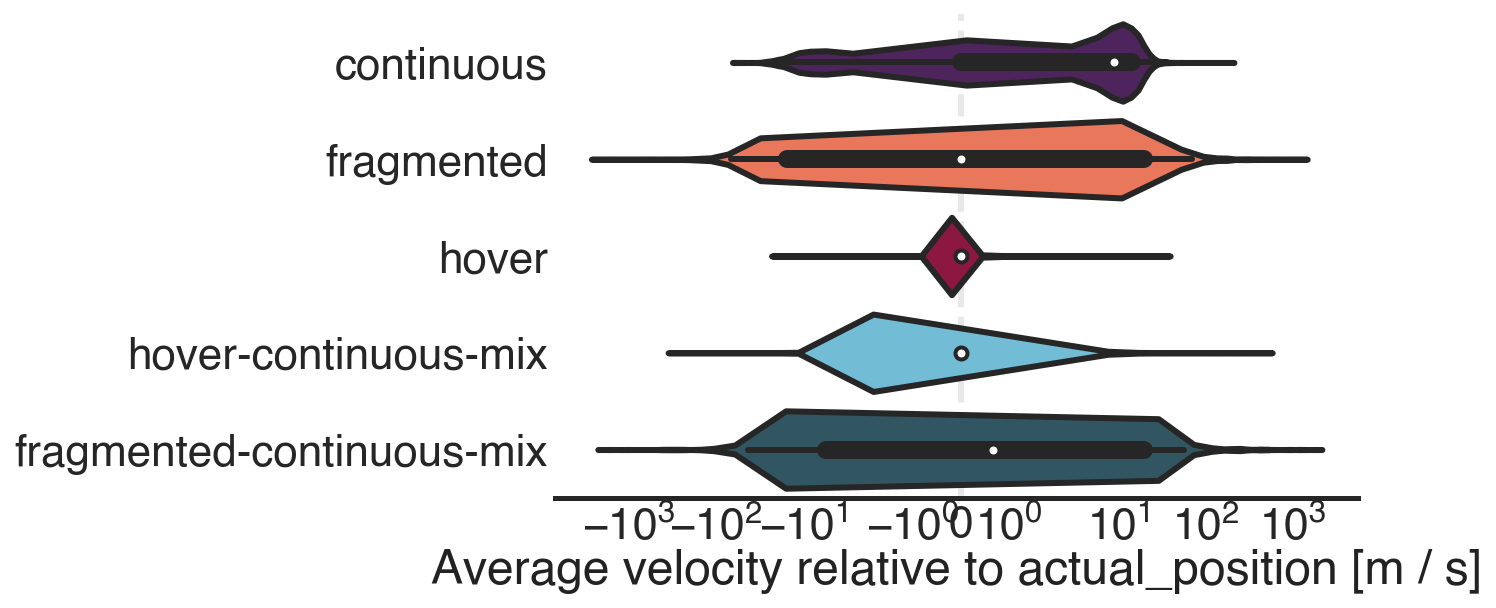

In [24]:
from src.visualization import plot_replay_velocity

plt.figure()
plot_replay_velocity(replay_info, relative_to='actual_position', bw=0.1)
plt.xlim((-50, 50))


plt.figure()
plot_replay_velocity(replay_info, relative_to='actual_position', bw=0.1)
plt.gca().set_xscale('symlog')
save_figure('replay_velocity_relative_to_animal')

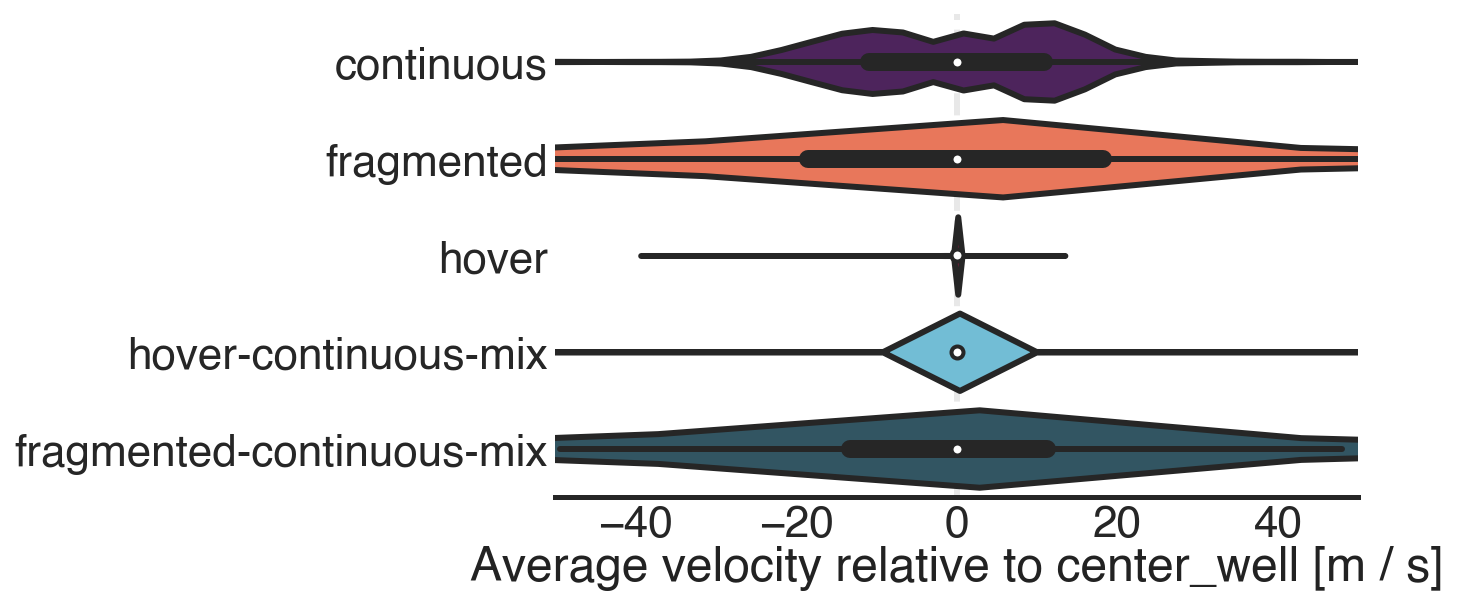

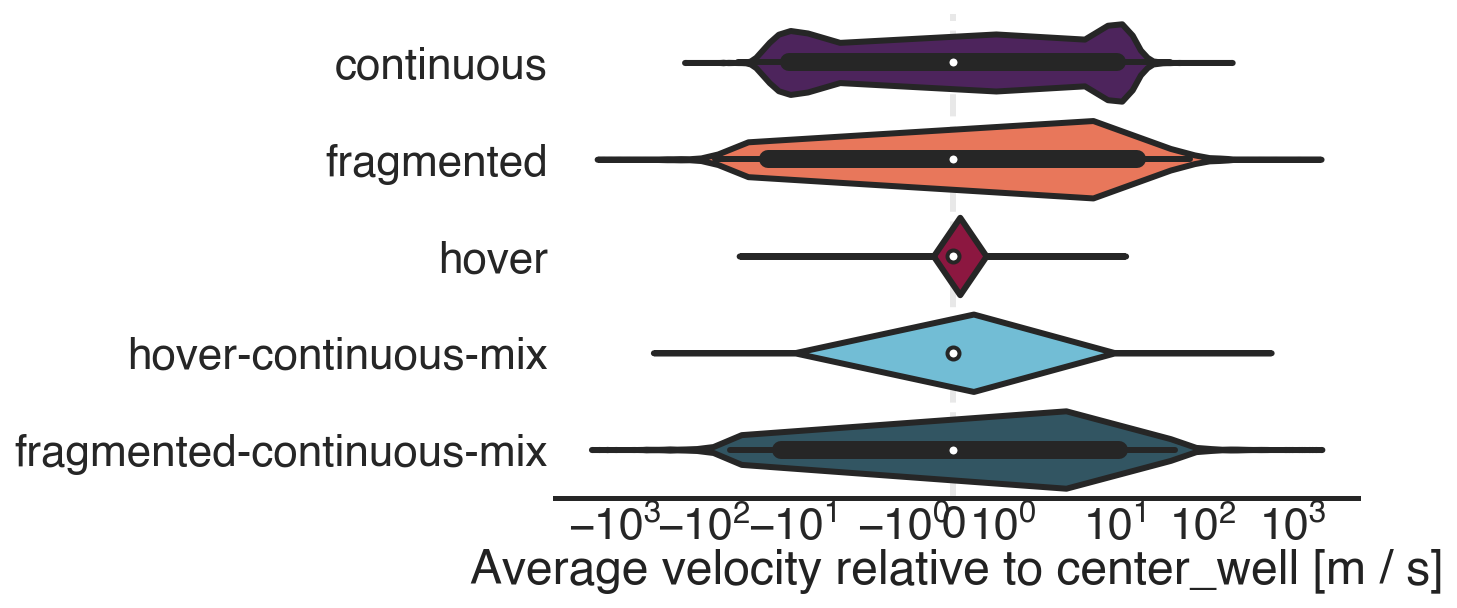

In [25]:
from src.visualization import plot_replay_velocity

plt.figure()
plot_replay_velocity(replay_info, relative_to='center_well', bw=0.1)
plt.xlim((-50, 50))

plt.figure()
plot_replay_velocity(replay_info, relative_to='center_well', bw=0.1)
plt.gca().set_xscale('symlog')
save_figure('replay_velocity_relative_to_center_well')

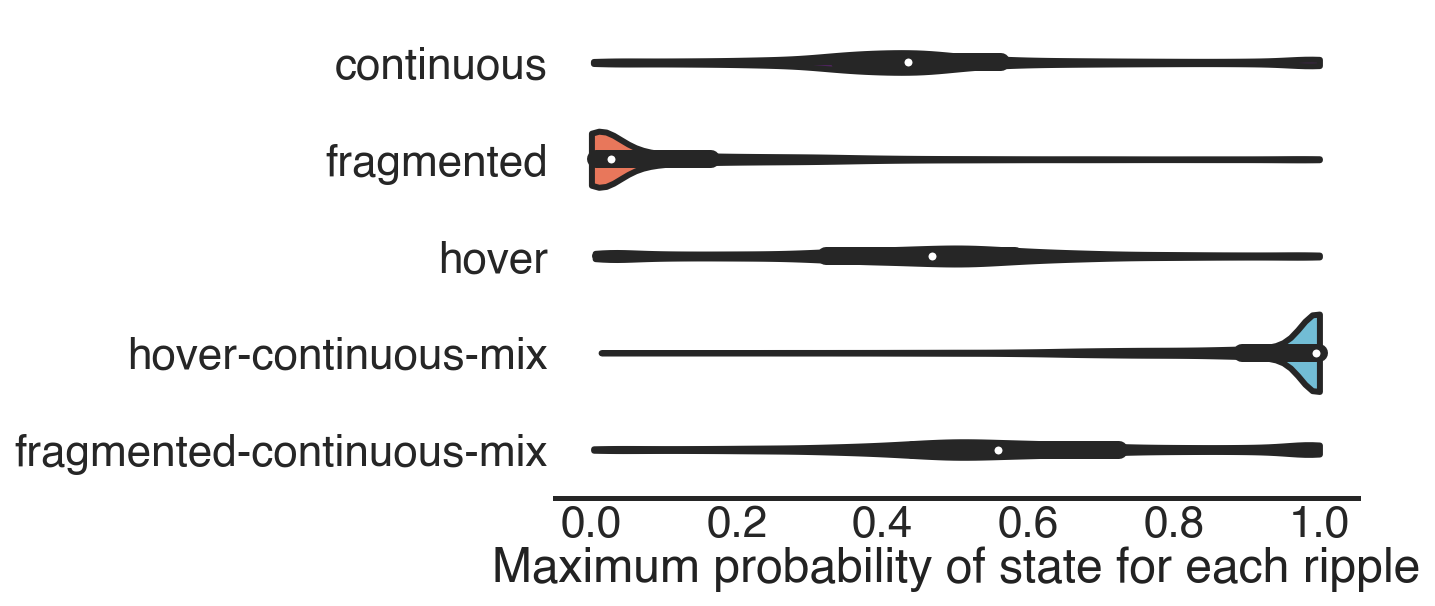

In [26]:
from src.visualization import plot_max_probability

plot_max_probability(replay_info, kind='violin')

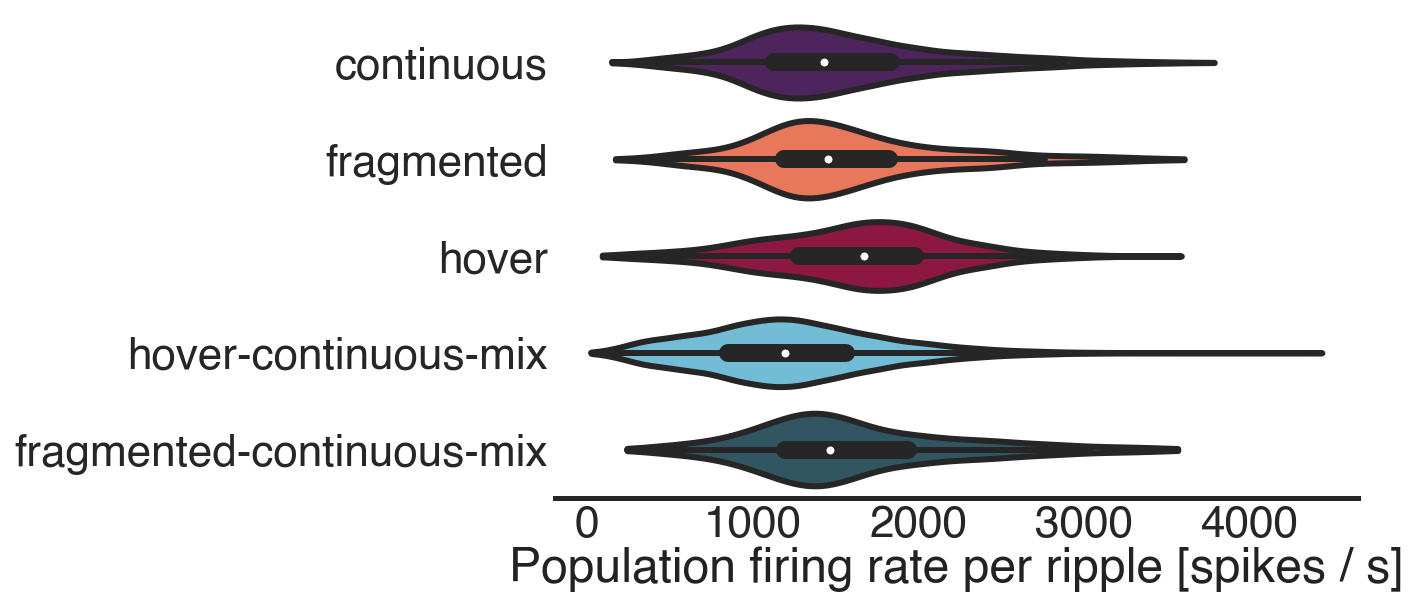

In [27]:
from src.visualization import plot_population_rate

plot_population_rate(replay_info)
save_figure('average_multiunit_rate')

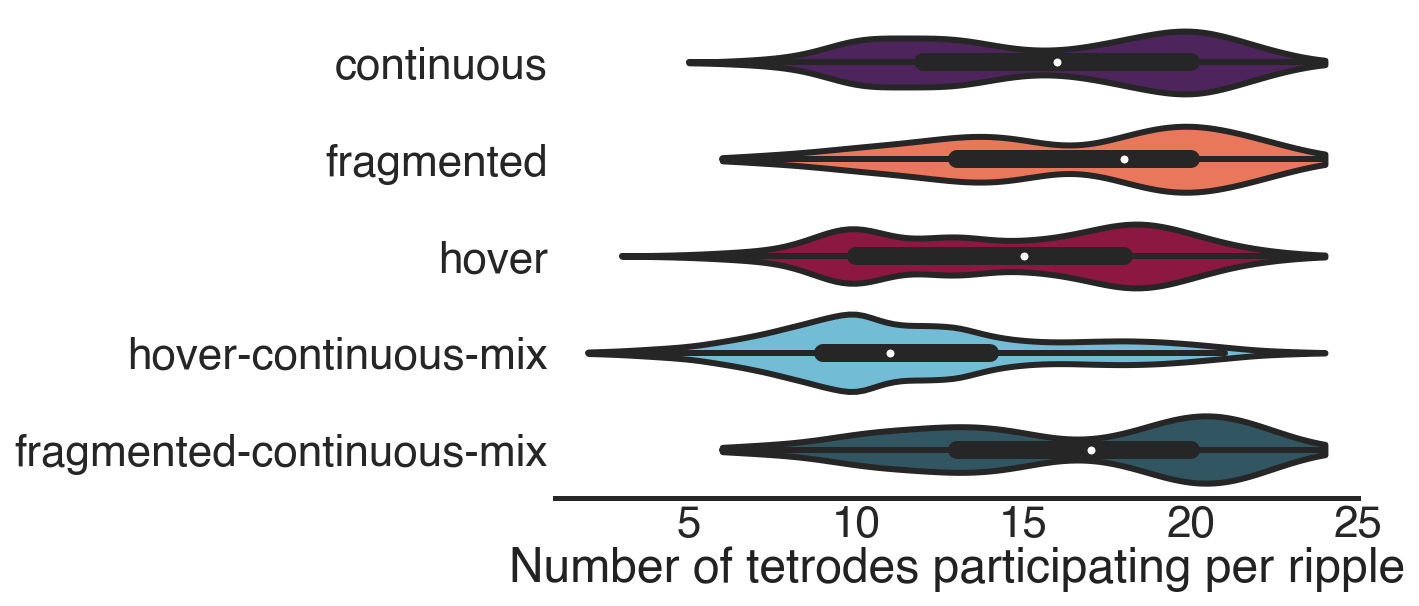

In [28]:
from src.visualization import plot_n_unique_spiking


plt.figure()
plot_n_unique_spiking(replay_info, kind='violin', data_type='tetrodes')
save_figure('n_unique_spiking')

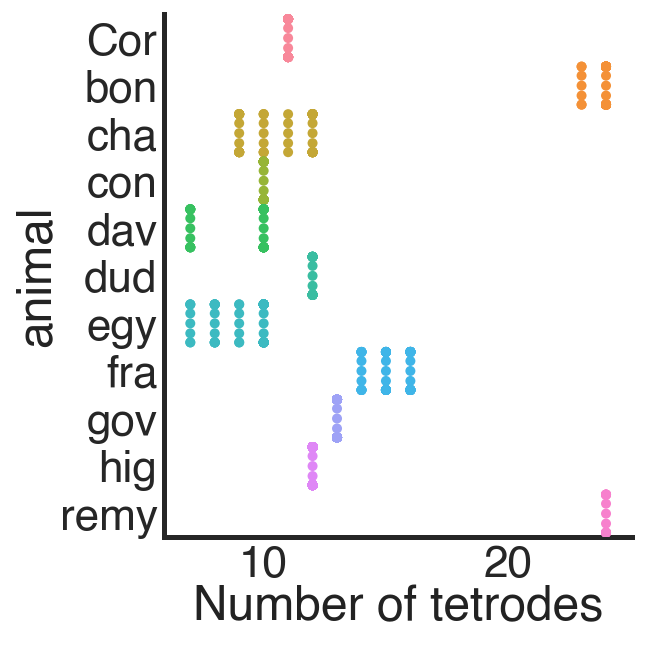

In [29]:
from loren_frank_data_processing import make_tetrode_dataframe, make_epochs_dataframe
from src.parameters import ANIMALS, _BRAIN_AREAS

epoch_info = make_epochs_dataframe(ANIMALS)
tetrode_info = make_tetrode_dataframe(ANIMALS)
is_brain_areas = (
        tetrode_info.area.astype(str).str.upper().isin(_BRAIN_AREAS))
n_tetrodes = (tetrode_info.loc[is_brain_areas]
              .groupby(['animal', 'day', 'epoch'])
              .tetrode_id
              .agg(len)
              .rename('n_tetrodes')
              .to_frame()
              .loc[epoch_info.index])
sns.catplot(x='n_tetrodes', y='animal', data=n_tetrodes.reset_index(), kind='swarm')
plt.xlabel('Number of tetrodes');
save_figure('n_tetrodes');